In [1]:
"""
============================================================
CELL 1: INSTALASI DEPENDENCIES & IMPORT LIBRARY DASAR
============================================================
Tujuan:
- Install library Roboflow untuk download dataset
- Install torchvision dan matplotlib untuk image processing
- Import library dasar untuk manipulasi gambar dan visualisasi

Library yang digunakan:
- roboflow: Download dataset dari Roboflow platform
- torchvision: PyTorch library untuk computer vision
- matplotlib: Visualisasi gambar dan plot
- PIL (Pillow): Image processing
"""

!pip install roboflow
!pip install torchvision matplotlib

import os, json
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import matplotlib.patches as patches

print("✅ Dependencies installed successfully!")


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Dependencies installed successfully!


In [2]:
"""
============================================================
CELL 2: DOWNLOAD DATASET DARI ROBOFLOW
============================================================
Tujuan:
- Connect ke Roboflow workspace menggunakan API key
- Download dataset anotasi wajah aslab dalam format COCO
- Dataset berisi gambar wajah dengan bounding box annotations

Output:
- Folder dataset dengan struktur:
  - train/: Gambar training
  - _annotations.coco.json: Anotasi COCO format

CATATAN KEAMANAN:
- API key sebaiknya disimpan di environment variable
- Jangan commit API key ke repository public
"""

from roboflow import Roboflow

# Connect ke Roboflow workspace
rf = Roboflow(api_key="wptfc24K1jabXxwja75u")
project = rf.workspace("a-kytup").project("computing_project-es8cq")
version = project.version(2)

# Download dataset dalam format COCO
dataset = version.download("coco")

print(f"✅ Dataset downloaded to: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...
✅ Dataset downloaded to: c:\Users\MAHARDIKA\OneDrive\Documents\compro\Computing_project-2


In [3]:
"""
============================================================
CELL 3: LOAD & PARSE COCO ANNOTATIONS
============================================================
Tujuan:
- Membaca file anotasi COCO JSON
- Membuat mapping dari image ID ke filename
- Membuat mapping dari category ID ke label nama aslab

Format COCO:
- images: [{id, file_name, width, height}, ...]
- annotations: [{id, image_id, category_id, bbox}, ...]
- categories: [{id, name}, ...]

Output:
- image_id_to_file: Dictionary untuk lookup filename dari image ID
- category_id_to_label: Dictionary untuk lookup nama aslab dari category ID
"""

# Path ke file anotasi COCO
json_path = os.path.join(dataset.location, "train/_annotations.coco.json")

# Load JSON
with open(json_path) as f:
    coco_data = json.load(f)

# Buat mapping untuk lookup cepat
image_id_to_file = {img["id"]: img["file_name"] for img in coco_data["images"]}
category_id_to_label = {cat["id"]: cat["name"] for cat in coco_data["categories"]}

print(f"✅ Loaded {len(coco_data['images'])} images")
print(f"✅ Found {len(coco_data['annotations'])} face annotations")
print(f"✅ Classes: {list(category_id_to_label.values())}")

✅ Loaded 2425 images
✅ Found 2092 face annotations
✅ Classes: ['iksan', 'akbar', 'aprilianza', 'bian', 'fadhilah', 'falah', 'iksan', 'imelda', 'rifqy', 'yolanda']


In [4]:
"""
============================================================
CELL 4: FUNGSI VISUALISASI BOUNDING BOX
============================================================
Tujuan:
- Membuat fungsi untuk visualisasi bounding box pada gambar
- Menampilkan label nama aslab di atas bbox

Parameter:
- image_path: Path ke file gambar
- bbox: [x, y, width, height] dalam format COCO
- label: Nama aslab

Kegunaan:
- Debugging: Cek apakah anotasi bbox sudah benar
- Visualisasi: Lihat hasil deteksi
"""

def visualize_bbox(image_path, bbox, label):
    """
    Visualisasi bounding box pada gambar

    Args:
        image_path (str): Path ke gambar
        bbox (list): [x, y, w, h] bounding box
        label (str): Label nama aslab
    """
    # Load gambar
    image = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(image)

    # Parse bbox coordinates
    x, y, w, h = bbox

    # Gambar rectangle
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # Tambah label text
    ax.text(x, y - 5, label, color='red', fontsize=12, weight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    plt.axis("off")
    plt.title(f"Face Detection: {label}", fontsize=14, weight='bold')
    plt.show()

print("✅ Visualization function ready!")

✅ Visualization function ready!


Sample annotation:
  - Image: WIN_20251018_18_05_44_Pro_mp4-0020_jpg.rf.a45529ef367bea1eb75489284471e85c.jpg
  - Label: fadhilah
  - Bbox: [536, 181, 152.5, 197.5]



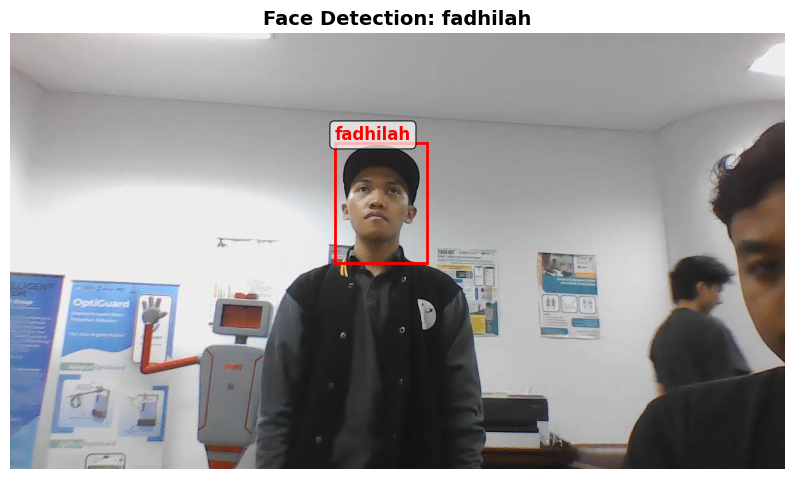

In [5]:
"""
============================================================
CELL 5: TEST VISUALISASI PADA SAMPLE ANNOTATION
============================================================
Tujuan:
- Mengambil satu sample annotation dari dataset
- Visualisasi bbox untuk verifikasi data quality
- Memastikan mapping image_id dan category_id bekerja

Output:
- Tampilan gambar dengan bounding box merah
- Label nama aslab di atas bbox

Gunakan ini untuk:
- Quality check dataset
- Memastikan anotasi sudah benar sebelum training
"""

# Ambil annotation pertama sebagai sample
sample_ann = coco_data["annotations"][0]

# Lookup image dan label
image_id = sample_ann["image_id"]
bbox = sample_ann["bbox"]
label = category_id_to_label[sample_ann["category_id"]]
file_name = image_id_to_file[image_id]
image_path = os.path.join(dataset.location, "train", file_name)

# Visualisasi
print(f"Sample annotation:")
print(f"  - Image: {file_name}")
print(f"  - Label: {label}")
print(f"  - Bbox: {bbox}\n")

visualize_bbox(image_path, bbox, label)

In [6]:
"""
============================================================
CELL 6: CROP SEMUA WAJAH DARI DATASET
============================================================
Tujuan:
- Crop setiap wajah berdasarkan bounding box annotations
- Simpan crop per label (nama aslab) ke folder terpisah
- Persiapan data untuk training classifier

Proses:
1. Loop semua annotations
2. Crop gambar sesuai bbox [x, y, w, h]
3. Simpan ke folder: cropped_faces/<label>/<filename>

Output struktur folder:
cropped_faces/
  ├── aslab_1/
  │   ├── img1.jpg
  │   ├── img2.jpg
  ├── aslab_2/
  │   ├── img3.jpg
  └── ...

Error handling:
- Skip jika gambar tidak bisa dibuka
- Print error message untuk debugging
"""

output_dir = "cropped_faces"
os.makedirs(output_dir, exist_ok=True)

print(f"🔄 Cropping {len(coco_data['annotations'])} faces...\n")

success_count = 0
error_count = 0

# Loop semua annotations
for ann in coco_data["annotations"]:
    image_id = ann["image_id"]
    bbox = ann["bbox"]
    label = category_id_to_label[ann["category_id"]]
    file_name = image_id_to_file[image_id]
    image_path = os.path.join(dataset.location, "train", file_name)

    try:
        # Load gambar
        image = Image.open(image_path).convert("RGB")

        # Parse bbox dan crop
        x, y, w, h = map(int, bbox)
        face_crop = image.crop((x, y, x + w, y + h))

        # Buat folder per label
        label_dir = os.path.join(output_dir, label)
        os.makedirs(label_dir, exist_ok=True)

        # Simpan crop
        save_path = os.path.join(label_dir, file_name)
        face_crop.save(save_path)
        success_count += 1

    except Exception as e:
        print(f"[ERROR] Gagal crop {file_name}: {e}")
        error_count += 1

print(f"\n✅ Cropping complete!")
print(f"   Success: {success_count}")
print(f"   Errors: {error_count}")

🔄 Cropping 2092 faces...


✅ Cropping complete!
   Success: 2092
   Errors: 0


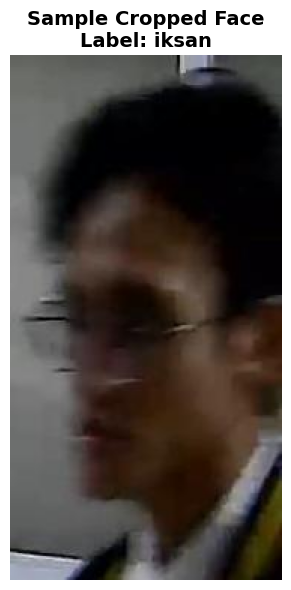

✅ Sample from class: iksan
   Image size: (181, 350)


In [7]:
"""
============================================================
CELL 7: VERIFIKASI HASIL CROPPING
============================================================
Tujuan:
- Menampilkan sample hasil cropping
- Verifikasi bahwa crop sudah benar (hanya wajah, tidak ada background berlebih)

Output:
- Tampilan satu sample crop dari label pertama
- Memastikan quality crop bagus untuk training

Tips:
- Jika crop terlalu ketat/longgar, adjust padding di cell sebelumnya
- Pastikan wajah terlihat jelas dan tidak terpotong
"""

# Ambil sample dari label pertama
sample_label = list(category_id_to_label.values())[0]
sample_folder = os.path.join(output_dir, sample_label)
sample_image = os.listdir(sample_folder)[0]

# Load dan tampilkan
img = Image.open(os.path.join(sample_folder, sample_image))

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Sample Cropped Face\nLabel: {sample_label}", fontsize=14, weight='bold')
plt.axis("off")
plt.tight_layout()
plt.show()

print(f"✅ Sample from class: {sample_label}")
print(f"   Image size: {img.size}")

📸 DAFTAR ASLAB - SAMPLE WAJAH
1. akbar           -  293 images
2. aprilianza      -  293 images
3. bian            -  116 images
4. fadhilah        -  296 images
5. falah           -  332 images
6. iksan           -  296 images
7. imelda          -  165 images
8. rifqy           -  175 images
9. yolanda         -  119 images


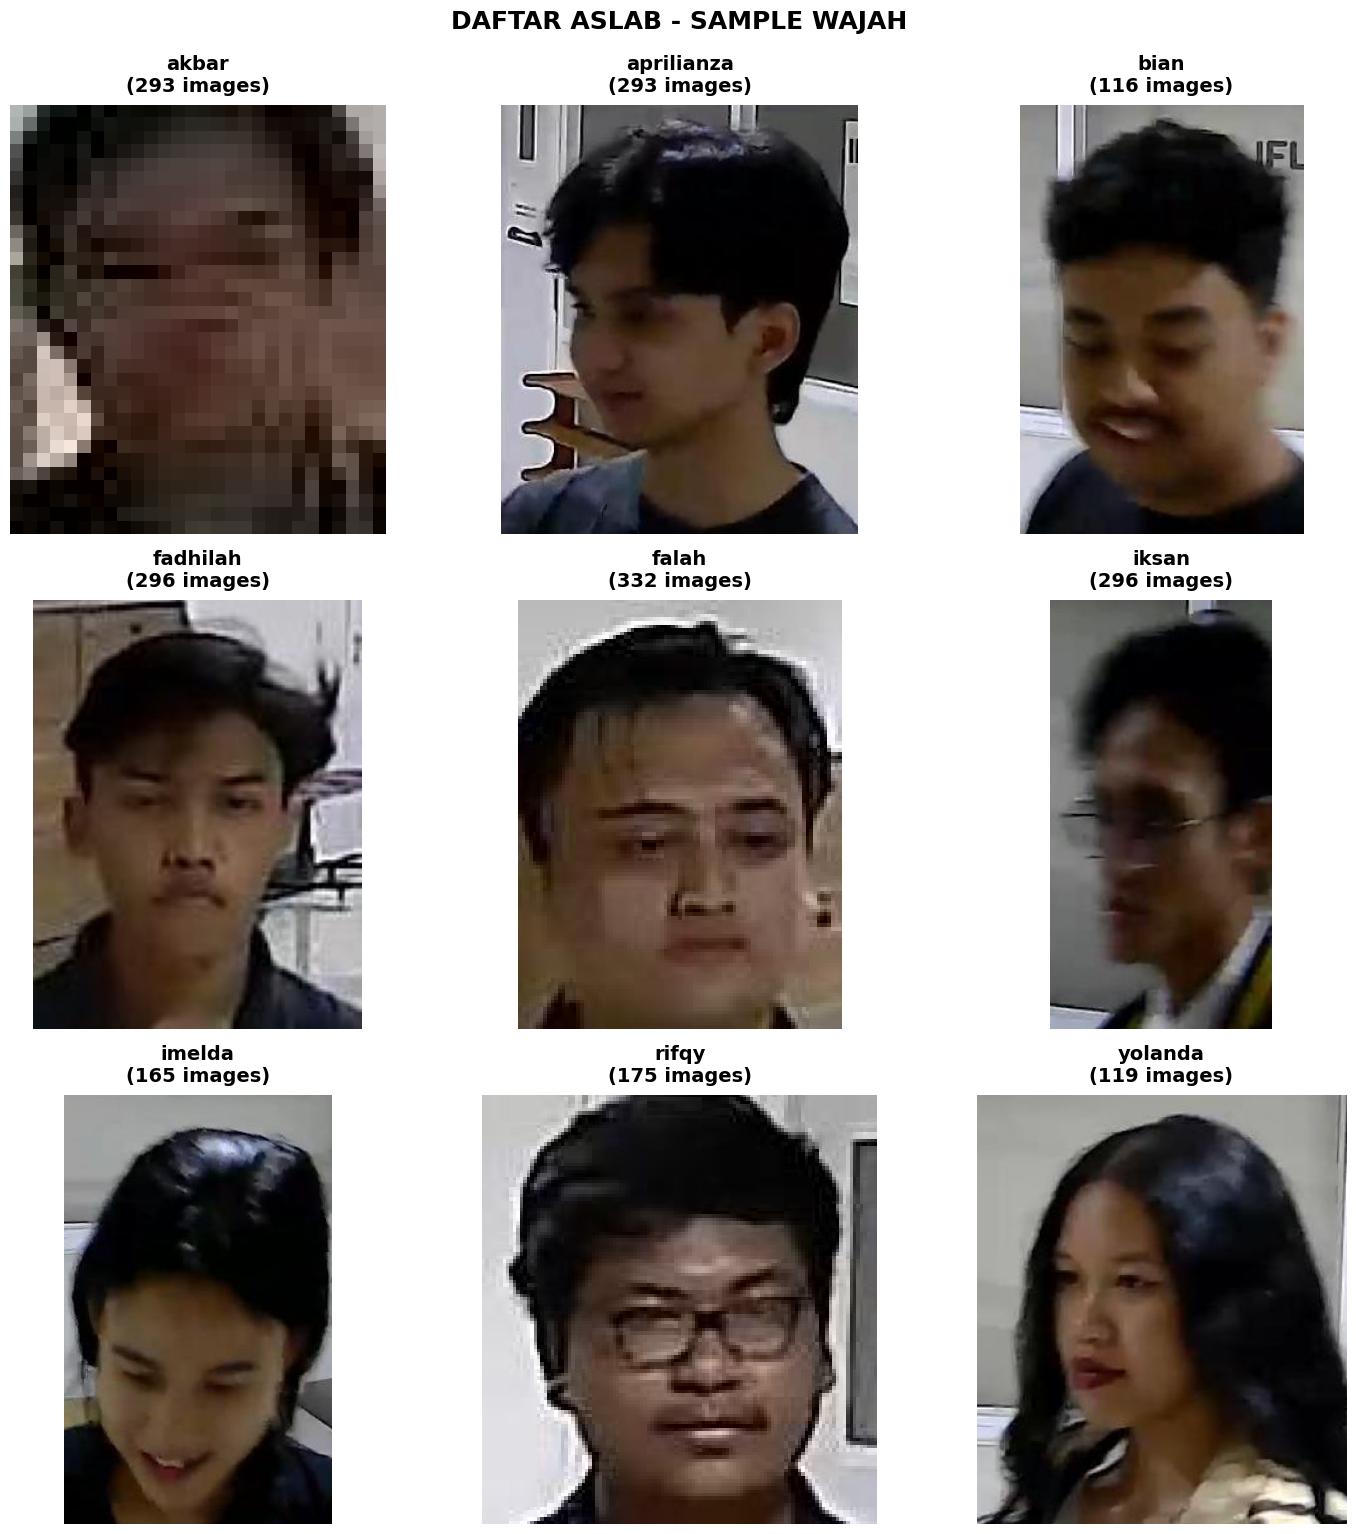

✅ Total: 9 aslab dengan 2085 gambar

Catatan:
  - Setiap aslab ditampilkan dengan 1 sample wajah
  - Pastikan semua wajah terlihat jelas
  - Jika ada yang blur/terpotong, check dataset quality


In [8]:
"""
============================================================
CELL 7.5: TAMPILKAN SEMUA SAMPLE WAJAH ASLAB
============================================================
Tujuan:
- Menampilkan sample wajah dari SETIAP aslab
- Visual overview dataset sebelum training
- Quality check: pastikan semua aslab punya data yang bagus

Output:
- Grid display dengan 1 sample per aslab
- Nama aslab di bawah setiap gambar
- Jumlah total gambar per aslab

Layout:
- Automatic grid layout (3 kolom)
- Responsive sizing
- Clean dan professional

Kegunaan:
- Quick visual check dataset
- Pastikan tidak ada class yang missing
- Lihat variasi wajah per aslab
"""

import math

# Get all labels
all_labels = sorted(os.listdir(output_dir))
num_labels = len(all_labels)

# Calculate grid size (3 columns)
cols = 3
rows = math.ceil(num_labels / cols)

# Create figure
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten() if num_labels > 1 else [axes]

print("📸 DAFTAR ASLAB - SAMPLE WAJAH")
print("="*60)

for idx, label in enumerate(all_labels):
    label_folder = os.path.join(output_dir, label)
    images = os.listdir(label_folder)

    # Ambil sample pertama
    sample_img_path = os.path.join(label_folder, images[0])
    img = Image.open(sample_img_path)

    # Display
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f"{label}\n({len(images)} images)",
                        fontsize=14, weight='bold', pad=10)

    # Print info
    print(f"{idx+1}. {label:15s} - {len(images):4d} images")

# Hide empty subplots
for idx in range(num_labels, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle("DAFTAR ASLAB - SAMPLE WAJAH", fontsize=18, weight='bold', y=1.02)
plt.show()

print("="*60)
print(f"✅ Total: {num_labels} aslab dengan {sum([len(os.listdir(os.path.join(output_dir, l))) for l in all_labels])} gambar")
print("\nCatatan:")
print("  - Setiap aslab ditampilkan dengan 1 sample wajah")
print("  - Pastikan semua wajah terlihat jelas")
print("  - Jika ada yang blur/terpotong, check dataset quality")

📸 DETAIL SAMPLES - SEMUA ASLAB
Menampilkan 5 sample per aslab

✓ akbar           -  293 images (5 samples shown)
✓ aprilianza      -  293 images (5 samples shown)
✓ bian            -  116 images (5 samples shown)
✓ fadhilah        -  296 images (5 samples shown)
✓ falah           -  332 images (5 samples shown)
✓ iksan           -  296 images (5 samples shown)
✓ imelda          -  165 images (5 samples shown)
✓ rifqy           -  175 images (5 samples shown)
✓ yolanda         -  119 images (5 samples shown)


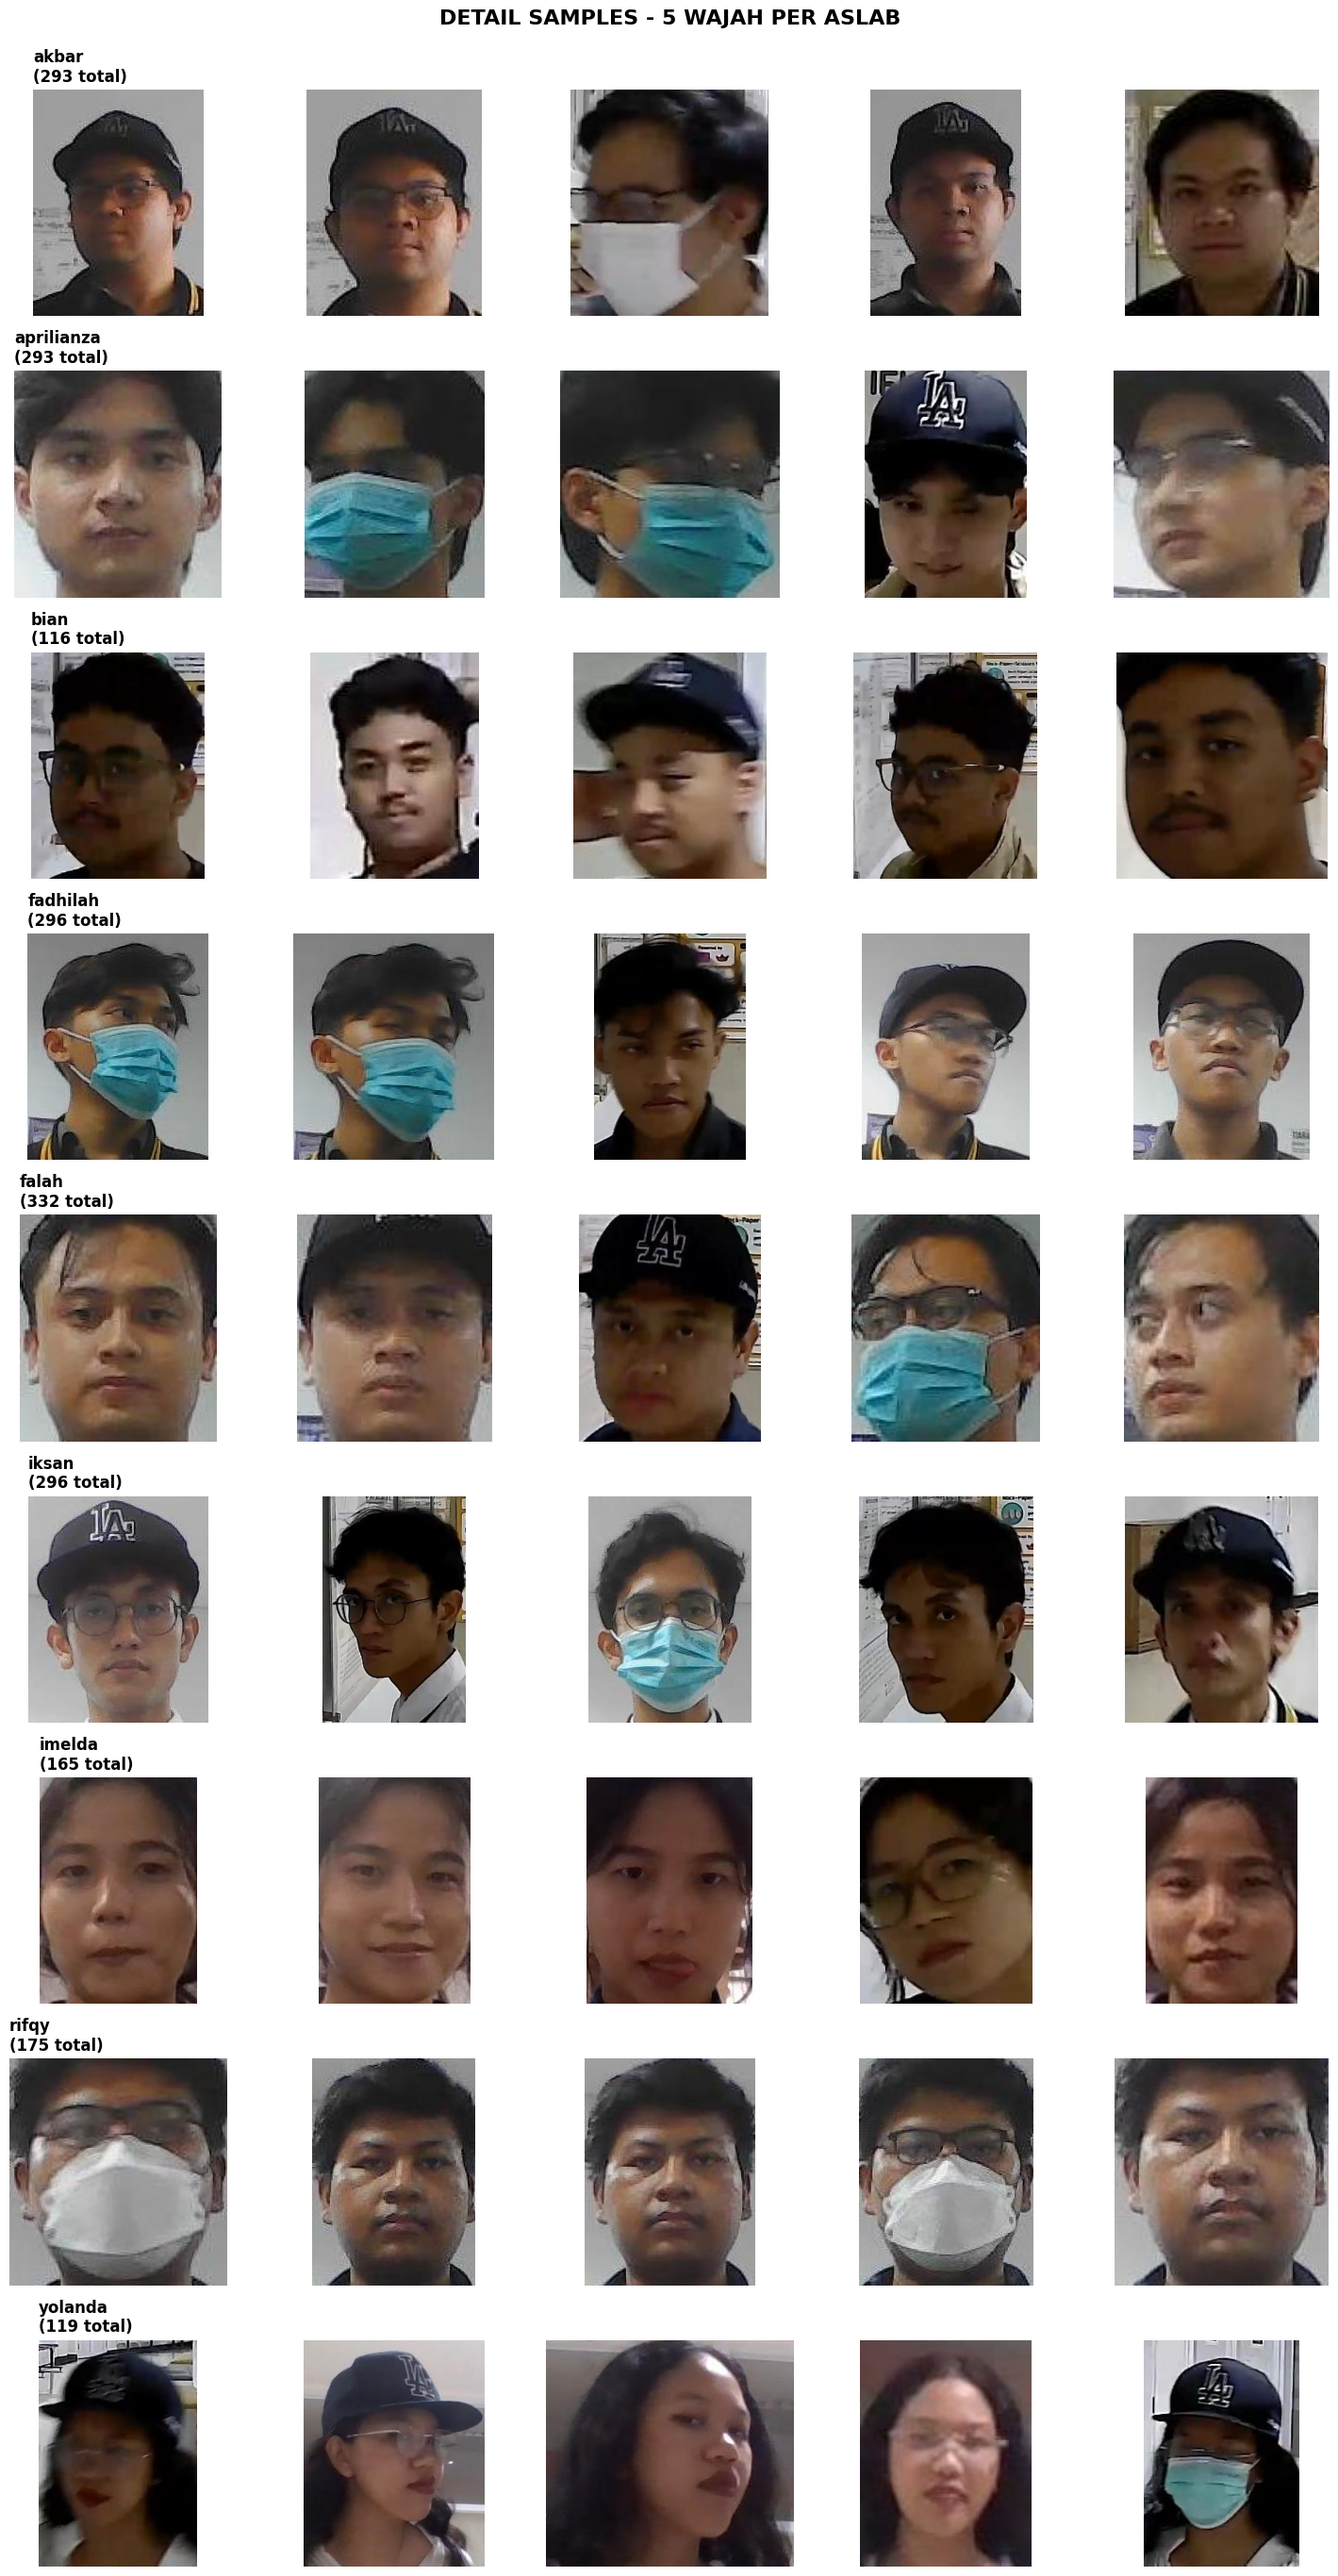


✅ Display complete!

Tips:
  - Check apakah semua wajah terlihat jelas
  - Perhatikan variasi pose dan lighting
  - Jika ada yang blur, consider remove dari dataset


In [9]:
"""
============================================================
CELL 8: TAMPILKAN MULTIPLE SAMPLES PER ASLAB (DETAIL)
============================================================
Tujuan:
- Menampilkan BEBERAPA sample wajah per aslab (tidak cuma 1)
- Lihat variasi pose, lighting, ekspresi
- Quality check lebih detail

Output:
- Grid besar dengan 5 sample per aslab
- Setiap row = 1 aslab
- Setiap column = 1 sample berbeda

Layout:
- Rows: Jumlah aslab
- Columns: 5 samples per aslab
- Total: aslab_count × 5 images

Kegunaan:
- Lihat variasi data per aslab
- Check consistency quality
- Identifikasi potential issues (blur, lighting, dll)
"""

import random

# Configuration
samples_per_aslab = 5
all_labels = sorted(os.listdir(output_dir))

print("📸 DETAIL SAMPLES - SEMUA ASLAB")
print("="*60)
print(f"Menampilkan {samples_per_aslab} sample per aslab\n")

# Create large figure
fig, axes = plt.subplots(len(all_labels), samples_per_aslab,
                         figsize=(samples_per_aslab * 3, len(all_labels) * 3))

# Handle single row case
if len(all_labels) == 1:
    axes = [axes]

for row_idx, label in enumerate(all_labels):
    label_folder = os.path.join(output_dir, label)
    images = os.listdir(label_folder)

    # Ambil random samples (atau semua jika kurang dari samples_per_aslab)
    num_samples = min(samples_per_aslab, len(images))
    sample_images = random.sample(images, num_samples) if len(images) > samples_per_aslab else images

    # Display samples
    for col_idx in range(samples_per_aslab):
        ax = axes[row_idx][col_idx] if len(all_labels) > 1 else axes[col_idx]

        if col_idx < len(sample_images):
            # Load dan display image
            img_path = os.path.join(label_folder, sample_images[col_idx])
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis('off')

            # Title hanya di kolom pertama
            if col_idx == 0:
                ax.set_title(f"{label}\n({len(images)} total)",
                           fontsize=12, weight='bold', loc='left')
        else:
            # Hide empty cells jika images kurang dari samples_per_aslab
            ax.axis('off')

    print(f"✓ {label:15s} - {len(images):4d} images ({num_samples} samples shown)")

plt.tight_layout()
plt.suptitle(f"DETAIL SAMPLES - {samples_per_aslab} WAJAH PER ASLAB",
             fontsize=16, weight='bold', y=1.01)
plt.show()

print("\n" + "="*60)
print("✅ Display complete!")
print("\nTips:")
print("  - Check apakah semua wajah terlihat jelas")
print("  - Perhatikan variasi pose dan lighting")
print("  - Jika ada yang blur, consider remove dari dataset")

In [10]:
"""
============================================================
CELL 9: REORGANISASI DATASET UNTUK TRAINING VIT
============================================================
Tujuan:
- Copy cropped faces ke struktur folder untuk ImageFolder loader
- Persiapan format dataset yang compatible dengan PyTorch

Struktur input (cropped_faces):
cropped_faces/
  ├── aslab_1/
  ├── aslab_2/
  └── ...

Struktur output (vit_dataset):
vit_dataset/
  └── train/
      ├── aslab_1/
      ├── aslab_2/
      └── ...

Kenapa perlu reorganisasi?
- PyTorch ImageFolder expects: root/class/images.jpg
- Memisahkan train/val/test di step berikutnya
- Clean separation antara raw data dan training data
"""

import shutil

# Folder sumber dan target
source_dir = "cropped_faces"
target_dir = "vit_dataset"
os.makedirs(target_dir, exist_ok=True)

print("📁 Reorganizing dataset for ViT training...\n")

# Copy per label ke folder train
for label in os.listdir(source_dir):
    src_label_dir = os.path.join(source_dir, label)
    dst_label_dir = os.path.join(target_dir, "train", label)
    os.makedirs(dst_label_dir, exist_ok=True)

    # Copy semua gambar
    image_count = 0
    for img_file in os.listdir(src_label_dir):
        src_path = os.path.join(src_label_dir, img_file)
        dst_path = os.path.join(dst_label_dir, img_file)
        shutil.copy(src_path, dst_path)
        image_count += 1

    print(f"✓ {label}: {image_count} images copied")

print(f"\n✅ Dataset reorganized to: {target_dir}/")

📁 Reorganizing dataset for ViT training...

✓ akbar: 293 images copied
✓ aprilianza: 293 images copied
✓ bian: 116 images copied
✓ fadhilah: 296 images copied
✓ falah: 332 images copied
✓ iksan: 296 images copied
✓ imelda: 165 images copied
✓ rifqy: 175 images copied
✓ yolanda: 119 images copied

✅ Dataset reorganized to: vit_dataset/


In [11]:
"""
============================================================
CELL 9: INSTALL TRANSFORMERS & SETUP VIT
============================================================
Tujuan:
- Install Hugging Face Transformers untuk ViT model
- Install datasets library untuk data processing
- Import library yang diperlukan untuk training

Library:
- transformers: Pre-trained ViT models dari Hugging Face
- datasets: Data loading utilities
- torch: PyTorch deep learning framework
- torchvision: Computer vision utilities

Model yang akan digunakan:
- google/vit-base-patch16-224-in21k
  - Pre-trained on ImageNet-21k (14M images, 21k classes)
  - Input size: 224x224
  - Patch size: 16x16
  - Base architecture (12 layers, 768 hidden dim)
"""

!pip install transformers datasets

from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

print("✅ Transformers library installed!")
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


✅ Transformers library installed!
✅ PyTorch version: 2.10.0.dev20251016+cu128
✅ CUDA available: True


In [12]:
"""
============================================================
CELL 10: SETUP TRANSFORMS & LOAD INITIAL DATASET
============================================================
Tujuan:
- Definisikan image transformations untuk preprocessing
- Load dataset menggunakan ImageFolder
- Initialize ViT model dengan jumlah kelas sesuai dataset

Transforms Pipeline:
1. Resize(224, 224): ViT requires fixed 224x224 input
2. ToTensor(): Convert PIL Image to tensor [0, 1]
3. Normalize([0.5]*3, [0.5]*3): Normalize to [-1, 1]
   - Mean = 0.5 untuk RGB channels
   - Std = 0.5 untuk RGB channels

Model Architecture:
- Base: google/vit-base-patch16-224-in21k (pre-trained)
- Modified: Classification head disesuaikan dengan num_classes
- Weights: Pre-trained ImageNet-21k (transfer learning)

CATATAN:
- Cell ini akan di-override di cell berikutnya setelah train/val split
- Ini hanya untuk initial setup dan verifikasi
"""

# Define transforms (sama seperti ViT pre-training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),           # Resize ke 224x224
    transforms.ToTensor(),                   # Convert ke tensor
    transforms.Normalize([0.5]*3, [0.5]*3)   # Normalize ke [-1, 1]
])

# Load dataset (sementara, akan di-split di cell berikutnya)
train_dataset = datasets.ImageFolder(root="vit_dataset/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Initialize ViT model
num_classes = len(train_dataset.classes)
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes,
    ignore_mismatched_sizes=True  # Allow classifier head resize
)

print(f"✅ Dataset loaded: {len(train_dataset)} images")
print(f"✅ Number of classes: {num_classes}")
print(f"✅ Classes: {train_dataset.classes}")
print(f"✅ ViT model initialized with {num_classes} output classes")

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MAHARDIKA\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this 

✅ Dataset loaded: 2085 images
✅ Number of classes: 9
✅ Classes: ['akbar', 'aprilianza', 'bian', 'fadhilah', 'falah', 'iksan', 'imelda', 'rifqy', 'yolanda']
✅ ViT model initialized with 9 output classes


In [13]:
"""
============================================================
CELL 11: BASIC TRAINING LOOP (ORIGINAL - DEPRECATED)
============================================================
⚠️ CATATAN: Cell ini adalah training loop original (tanpa validation)
⚠️ SKIP cell ini dan langsung ke CELL 12 untuk training yang lebih baik

Cell ini disimpan untuk referensi, tapi TIDAK PERLU DIJALANKAN.

Masalah dengan training loop ini:
- Tidak ada validation split
- Tidak ada early stopping
- Tidak ada model saving
- Tidak ada metrics tracking
- Risk overfitting karena tidak ada monitoring

Gunakan CELL 12-14 untuk training pipeline yang proper!
"""

# DEPRECATED - DO NOT RUN
# Uncomment jika ingin run training sederhana (not recommended)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# loss_fn = torch.nn.CrossEntropyLoss()

# for epoch in range(5):
#     total_loss = 0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images).logits
#         loss = loss_fn(outputs, labels)

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         total_loss += loss.item()

#     print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

print("⚠️  SKIP this cell - Use improved training in CELL 12 instead!")
print("✅ Proceed to CELL 12 for proper train/val split and evaluation")

⚠️  SKIP this cell - Use improved training in CELL 12 instead!
✅ Proceed to CELL 12 for proper train/val split and evaluation


In [14]:
"""
============================================================
CELL 12: CREATE TRAIN/VALIDATION SPLIT
============================================================
Tujuan:
- Split dataset menjadi train (80%) dan validation (20%)
- Validation set untuk monitoring overfitting
- Stratified split per class untuk balanced evaluation

Proses:
1. Scan semua images di vit_dataset/train/<class>/
2. Shuffle images per class (dengan seed untuk reproducibility)
3. Split 80% train, 20% validation
4. Move validation images ke vit_dataset/val/<class>/

Output struktur:
vit_dataset/
  ├── train/
  │   ├── aslab_1/  (80% images)
  │   ├── aslab_2/
  │   └── ...
  └── val/
      ├── aslab_1/  (20% images)
      ├── aslab_2/
      └── ...

Parameter:
- train_ratio: 0.8 (80% train, 20% val)
- seed: 42 (untuk reproducibility)

Kenapa validation penting?
- Deteksi overfitting
- Model selection (save best model)
- Estimasi performa real-world
"""

import random
from pathlib import Path

def create_train_val_split(source_dir, train_ratio=0.8, seed=42):
    """
    Split cropped faces into train and val folders

    Args:
        source_dir: Base directory (not used, kept for compatibility)
        train_ratio: Percentage for training (default 0.8)
        seed: Random seed for reproducibility
    """
    random.seed(seed)

    train_dir = Path("vit_dataset/train")
    val_dir = Path("vit_dataset/val")
    val_dir.mkdir(parents=True, exist_ok=True)

    print("🔄 Splitting dataset into train/val...\n")

    total_train = 0
    total_val = 0

    # Loop setiap class folder
    for label_folder in train_dir.iterdir():
        if not label_folder.is_dir():
            continue

        label = label_folder.name
        val_label_dir = val_dir / label
        val_label_dir.mkdir(exist_ok=True)

        # Get all images
        images = list(label_folder.glob("*"))
        random.shuffle(images)

        # Split berdasarkan ratio
        split_idx = int(len(images) * train_ratio)
        val_images = images[split_idx:]

        # Move ke validation folder
        for img_path in val_images:
            shutil.move(str(img_path), str(val_label_dir / img_path.name))

        total_train += split_idx
        total_val += len(val_images)

        print(f"✓ {label}: {split_idx} train, {len(val_images)} val")

    print(f"\n✅ Split complete!")
    print(f"   Total train: {total_train}")
    print(f"   Total val: {total_val}")
    print(f"   Ratio: {total_train/(total_train+total_val)*100:.1f}% / {total_val/(total_train+total_val)*100:.1f}%")

# Jalankan split
create_train_val_split("vit_dataset/train", train_ratio=0.8)

🔄 Splitting dataset into train/val...

✓ akbar: 234 train, 59 val
✓ aprilianza: 234 train, 59 val
✓ bian: 92 train, 24 val
✓ fadhilah: 236 train, 60 val
✓ falah: 265 train, 67 val
✓ iksan: 236 train, 60 val
✓ imelda: 132 train, 33 val
✓ rifqy: 140 train, 35 val
✓ yolanda: 95 train, 24 val

✅ Split complete!
   Total train: 1664
   Total val: 421
   Ratio: 79.8% / 20.2%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 TRAINING WITH EARLY STOPPING
Device: cuda
Train samples: 1664
Val samples: 421
Batches per epoch: 208
Classes: 9
Max epochs: 20
Early stopping patience: 3 epochs



Epoch 1/20 [Training]: 100%|████████| 208/208 [00:31<00:00,  6.61it/s, loss=0.6860, avg_loss=1.4367]



Epoch 1/20 - Running validation...


Epoch 1/20 Summary:
  Train Loss:     1.4367
  Val Loss:       0.7547
  Val Accuracy:   97.39%
  Learning Rate:  1.99e-05
  Epoch Time:     35.7s
  ✓ NEW BEST MODEL SAVED! (+97.39% improvement)
  Elapsed Time:   0.6m
  ETA:            11.6m (19 epochs left)



Epoch 2/20 [Training]: 100%|████████| 208/208 [00:25<00:00,  8.03it/s, loss=0.2918, avg_loss=0.4743]



Epoch 2/20 - Running validation...


Epoch 2/20 Summary:
  Train Loss:     0.4743
  Val Loss:       0.3456
  Val Accuracy:   98.81%
  Learning Rate:  1.95e-05
  Epoch Time:     28.4s
  ✓ NEW BEST MODEL SAVED! (+1.43% improvement)
  Elapsed Time:   1.1m
  ETA:            9.9m (18 epochs left)



Epoch 3/20 [Training]: 100%|████████| 208/208 [00:25<00:00,  8.08it/s, loss=0.2051, avg_loss=0.2393]



Epoch 3/20 - Running validation...


Epoch 3/20 Summary:
  Train Loss:     0.2393
  Val Loss:       0.2008
  Val Accuracy:   99.52%
  Learning Rate:  1.89e-05
  Epoch Time:     28.2s
  ✓ NEW BEST MODEL SAVED! (+0.71% improvement)
  Elapsed Time:   1.6m
  ETA:            9.0m (17 epochs left)



Epoch 4/20 [Training]: 100%|████████| 208/208 [00:25<00:00,  8.18it/s, loss=0.1271, avg_loss=0.1555]



Epoch 4/20 - Running validation...


Epoch 4/20 Summary:
  Train Loss:     0.1555
  Val Loss:       0.1410
  Val Accuracy:   100.00%
  Learning Rate:  1.81e-05
  Epoch Time:     27.8s
  ✓ NEW BEST MODEL SAVED! (+0.48% improvement)
  Elapsed Time:   2.1m
  ETA:            8.3m (16 epochs left)



Epoch 5/20 [Training]: 100%|████████| 208/208 [00:25<00:00,  8.28it/s, loss=0.1094, avg_loss=0.1153]



Epoch 5/20 - Running validation...


Epoch 5/20 Summary:
  Train Loss:     0.1153
  Val Loss:       0.1100
  Val Accuracy:   100.00%
  Learning Rate:  1.71e-05
  Epoch Time:     27.5s
  ○ No improvement (Best: 100.00%)
  ⚠ Epochs without improvement: 1/3
  Elapsed Time:   2.5m
  ETA:            7.6m (15 epochs left)



Epoch 6/20 [Training]: 100%|████████| 208/208 [00:24<00:00,  8.32it/s, loss=0.0865, avg_loss=0.0902]



Epoch 6/20 - Running validation...


Epoch 6/20 Summary:
  Train Loss:     0.0902
  Val Loss:       0.0876
  Val Accuracy:   100.00%
  Learning Rate:  1.59e-05
  Epoch Time:     27.5s
  ○ No improvement (Best: 100.00%)
  ⚠ Epochs without improvement: 2/3
  Elapsed Time:   3.0m
  ETA:            7.0m (14 epochs left)



Epoch 7/20 [Training]: 100%|████████| 208/208 [00:24<00:00,  8.46it/s, loss=0.0675, avg_loss=0.0737]



Epoch 7/20 - Running validation...


Epoch 7/20 Summary:
  Train Loss:     0.0737
  Val Loss:       0.0731
  Val Accuracy:   100.00%
  Learning Rate:  1.45e-05
  Epoch Time:     27.0s
  ○ No improvement (Best: 100.00%)
  ⚠ Epochs without improvement: 3/3
  Elapsed Time:   3.4m
  ETA:            6.4m (13 epochs left)


🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑
EARLY STOPPING TRIGGERED!
🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑🛑

Validation accuracy tidak improve selama 3 epoch berturut-turut.
Best validation accuracy: 100.00%
Training dihentikan di epoch 7/20
Total training time: 3.4 minutes

✅ Best model sudah tersimpan di: best_vit_aslab_model.pt

🎉 TRAINING COMPLETE (EARLY STOPPED)
Total Training Time: 3.4 minutes
Best Validation Accuracy: 100.00%
Total Epochs Run: 7/20
Final Train Loss: 0.0737
Final Val Loss: 0.0731


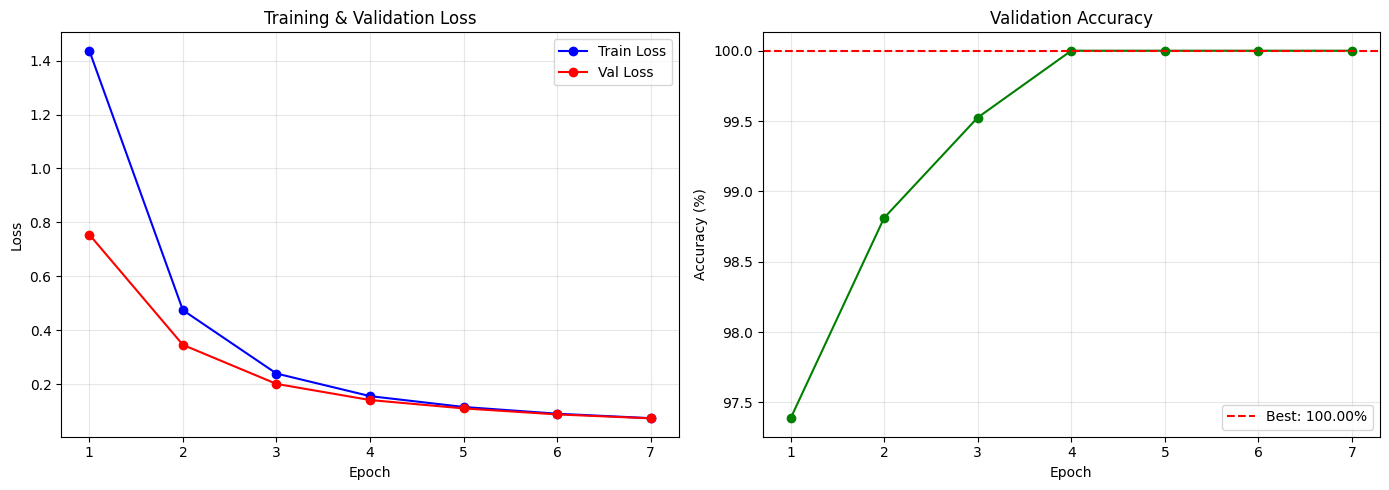


✅ Model saved to: best_vit_aslab_model.pt
✅ Training history plotted above


In [15]:
"""
============================================================
CELL 14: TRAINING WITH EARLY STOPPING & VALIDATION
============================================================
Tujuan:
- Training ViT model dengan validation monitoring
- EARLY STOPPING: Berhenti otomatis jika 3 epoch tidak ada improvement
- Track metrics dan save best model
- Prevent overfitting

Training Configuration:
- Optimizer: AdamW (Adam with weight decay)
  - Learning rate: 2e-5 (fine-tuning rate)
  - Weight decay: 0.01 (L2 regularization)
- Scheduler: CosineAnnealingLR (smooth LR decay)
- Loss: CrossEntropyLoss
- Batch size: 8
- Max epochs: 20 (bisa berhenti lebih awal)

EARLY STOPPING:
- Patience: 3 epochs
- Jika validation accuracy tidak improve selama 3 epoch berturut-turut → STOP
- Alasan: Mencegah overfitting dan waste computational resources
- Best model tetap tersimpan

Output:
- best_vit_aslab_model.pt: Best model checkpoint
- Training history: Loss & accuracy per epoch
- Early stopping notification jika triggered

Metrics Tracked:
- Train loss per epoch
- Validation loss per epoch
- Validation accuracy per epoch
- Best validation accuracy
- Epochs without improvement (untuk early stopping)
"""

from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm
import time

# Recreate datasets dengan train/val split
train_dataset = datasets.ImageFolder(root="vit_dataset/train", transform=transform)
val_dataset = datasets.ImageFolder(root="vit_dataset/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Reinitialize model
num_classes = len(train_dataset.classes)
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer dan scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss_fn = torch.nn.CrossEntropyLoss()

def evaluate(model, loader, device):
    """Evaluate model on validation set"""
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    val_pbar = tqdm(loader, desc="Validating", leave=False)

    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

            val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    acc = accuracy_score(all_labels, all_preds)
    return total_loss / len(loader), acc, all_preds, all_labels

# Training loop dengan EARLY STOPPING
best_val_acc = 0
epochs_without_improvement = 0
patience = 3  # Stop jika 3 epoch tidak ada improvement
max_epochs = 20

training_history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': []
}

print("🚀 TRAINING WITH EARLY STOPPING")
print("="*70)
print(f"Device: {device}")
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")
print(f"Classes: {num_classes}")
print(f"Max epochs: {max_epochs}")
print(f"Early stopping patience: {patience} epochs")
print("="*70)
print()

start_time = time.time()

for epoch in range(max_epochs):
    epoch_start = time.time()

    # TRAINING PHASE
    model.train()
    train_loss = 0

    train_pbar = tqdm(train_loader,
                      desc=f"Epoch {epoch+1}/{max_epochs} [Training]",
                      ncols=100)

    for batch_idx, (images, labels) in enumerate(train_pbar):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'avg_loss': f'{train_loss/(batch_idx+1):.4f}'
        })

    scheduler.step()

    # VALIDATION PHASE
    print(f"\nEpoch {epoch+1}/{max_epochs} - Running validation...")
    val_loss, val_acc, _, _ = evaluate(model, val_loader, device)

    epoch_time = time.time() - epoch_start

    # Store history
    avg_train_loss = train_loss / len(train_loader)
    training_history['train_loss'].append(avg_train_loss)
    training_history['val_loss'].append(val_loss)
    training_history['val_acc'].append(val_acc)

    # Print summary
    print("="*70)
    print(f"Epoch {epoch+1}/{max_epochs} Summary:")
    print(f"  Train Loss:     {avg_train_loss:.4f}")
    print(f"  Val Loss:       {val_loss:.4f}")
    print(f"  Val Accuracy:   {val_acc*100:.2f}%")
    print(f"  Learning Rate:  {scheduler.get_last_lr()[0]:.2e}")
    print(f"  Epoch Time:     {epoch_time:.1f}s")

    # Check for improvement
    if val_acc > best_val_acc:
        improvement = (val_acc - best_val_acc) * 100
        best_val_acc = val_acc
        epochs_without_improvement = 0

        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_to_idx': train_dataset.class_to_idx,
            'training_history': training_history
        }, 'best_vit_aslab_model.pt')

        print(f"  ✓ NEW BEST MODEL SAVED! (+{improvement:.2f}% improvement)")
    else:
        epochs_without_improvement += 1
        print(f"  ○ No improvement (Best: {best_val_acc*100:.2f}%)")
        print(f"  ⚠ Epochs without improvement: {epochs_without_improvement}/{patience}")

    # Estimate remaining time
    elapsed = time.time() - start_time
    avg_epoch_time = elapsed / (epoch + 1)
    remaining_epochs = max_epochs - (epoch + 1)
    eta = avg_epoch_time * remaining_epochs

    print(f"  Elapsed Time:   {elapsed/60:.1f}m")
    print(f"  ETA:            {eta/60:.1f}m ({remaining_epochs} epochs left)")
    print("="*70)
    print()

    # EARLY STOPPING CHECK
    if epochs_without_improvement >= patience:
        print("\n" + "🛑"*35)
        print("EARLY STOPPING TRIGGERED!")
        print("🛑"*35)
        print(f"\nValidation accuracy tidak improve selama {patience} epoch berturut-turut.")
        print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
        print(f"Training dihentikan di epoch {epoch+1}/{max_epochs}")
        print(f"Total training time: {(time.time() - start_time)/60:.1f} minutes")
        print("\n✅ Best model sudah tersimpan di: best_vit_aslab_model.pt")
        break

# Training complete summary
if epochs_without_improvement < patience:
    print("\n" + "="*70)
    print("🎉 TRAINING COMPLETE (ALL EPOCHS)")
    print("="*70)
else:
    print("\n" + "="*70)
    print("🎉 TRAINING COMPLETE (EARLY STOPPED)")
    print("="*70)

total_time = time.time() - start_time
print(f"Total Training Time: {total_time/60:.1f} minutes")
print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")
print(f"Total Epochs Run: {epoch+1}/{max_epochs}")
print(f"Final Train Loss: {training_history['train_loss'][-1]:.4f}")
print(f"Final Val Loss: {training_history['val_loss'][-1]:.4f}")
print("="*70)

# Plot training history
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_run = len(training_history['train_loss'])

# Loss plot
ax1.plot(range(1, epochs_run+1), training_history['train_loss'], 'b-o', label='Train Loss')
ax1.plot(range(1, epochs_run+1), training_history['val_loss'], 'r-o', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(range(1, epochs_run+1), [acc*100 for acc in training_history['val_acc']], 'g-o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Validation Accuracy')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=best_val_acc*100, color='r', linestyle='--', label=f'Best: {best_val_acc*100:.2f}%')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n✅ Model saved to: best_vit_aslab_model.pt")
print("✅ Training history plotted above")

In [16]:
"""
============================================================
CELL 15: SAVE MODEL ARTIFACTS & FINAL EVALUATION
============================================================
Tujuan:
- Simpan class mapping untuk inference
- Generate classification report lengkap
- Evaluasi final pada validation set

Output Files:
1. best_vit_aslab_model.pt (sudah disimpan di cell sebelumnya)
   - Model weights (state_dict)
   - Optimizer state
   - Best validation accuracy
   - Class mapping
   - Training history

2. class_mapping.json (baru)
   - class_to_idx: {"akbar": 0, "bian": 1, ...}
   - idx_to_class: {0: "akbar", 1: "bian", ...}
   - num_classes: total jumlah kelas

Classification Report:
- Precision: TP / (TP + FP) - akurasi prediksi positif
- Recall: TP / (TP + FN) - coverage dari true positives
- F1-score: 2 * (precision * recall) / (precision + recall)
- Support: jumlah sample per class di validation set

Metrics per class:
- Berguna untuk identifikasi class mana yang sulit dikenali
- Jika ada class dengan F1-score rendah, perlu tambah data
"""

# Save class mapping
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

import json
with open('class_mapping.json', 'w') as f:
    json.dump({
        'class_to_idx': class_to_idx,
        'idx_to_class': idx_to_class,
        'num_classes': num_classes
    }, f, indent=2)

print("✅ Saved artifacts:")
print("   - best_vit_aslab_model.pt (model checkpoint)")
print("   - class_mapping.json (class labels)")
print(f"\n📊 Classes detected ({num_classes} total):")
for idx, name in sorted(idx_to_class.items()):
    print(f"   {idx}: {name}")

# Final evaluation pada validation set
print("\n" + "="*60)
print("FINAL VALIDATION REPORT")
print("="*60)

val_loss, val_acc, val_preds, val_labels = evaluate(model, val_loader, device)
print(f"\nOverall Validation Accuracy: {val_acc*100:.2f}%")
print(f"Average Validation Loss: {val_loss:.4f}\n")

# Classification report per class
print("Per-Class Metrics:")
print("-" * 60)
print(classification_report(val_labels, val_preds,
                          target_names=list(class_to_idx.keys()),
                          zero_division=0))

print("\nMetrics Explanation:")
print("  - Precision: Akurasi ketika model prediksi class ini")
print("  - Recall: Persentase class ini yang berhasil dideteksi")
print("  - F1-score: Harmonic mean dari precision & recall")
print("  - Support: Jumlah sample di validation set")
print("\n✅ Evaluation complete!")

✅ Saved artifacts:
   - best_vit_aslab_model.pt (model checkpoint)
   - class_mapping.json (class labels)

📊 Classes detected (9 total):
   0: akbar
   1: aprilianza
   2: bian
   3: fadhilah
   4: falah
   5: iksan
   6: imelda
   7: rifqy
   8: yolanda

FINAL VALIDATION REPORT



Overall Validation Accuracy: 100.00%
Average Validation Loss: 0.0731

Per-Class Metrics:
------------------------------------------------------------
              precision    recall  f1-score   support

       akbar       1.00      1.00      1.00        59
  aprilianza       1.00      1.00      1.00        59
        bian       1.00      1.00      1.00        24
    fadhilah       1.00      1.00      1.00        60
       falah       1.00      1.00      1.00        67
       iksan       1.00      1.00      1.00        60
      imelda       1.00      1.00      1.00        33
       rifqy       1.00      1.00      1.00        35
     yolanda       1.00      1.00      1.00        24

    accuracy                           1.00       421
   macro avg       1.00      1.00      1.00       421
weighted avg       1.00      1.00      1.00       421


Metrics Explanation:
  - Precision: Akurasi ketika model prediksi class ini
  - Recall: Persentase class ini yang berhasil dideteksi
  - F1-sco

In [17]:
"""
============================================================
CELL 16: INSTALL MTCNN & DEPENDENCIES (ALTERNATIVE)
============================================================
Tujuan:
- Install MTCNN untuk face detection (GANTI RetinaFace)
- Install OpenCV untuk image processing
- Install scikit-learn untuk metrics
- MTCNN lebih kompatibel dengan PyTorch (no TensorFlow conflict)

Library yang diinstall:
1. mtcnn
   - Multi-task Cascaded Convolutional Networks
   - Deteksi wajah + facial landmarks
   - Pure PyTorch implementation (NO TensorFlow!)
   - Akurat dan cepat
   - Paper: "Joint Face Detection and Alignment using Multi-task Cascaded CNNs"

2. opencv-python
   - Image I/O dan processing
   - Video capture untuk webcam
   - Drawing utilities untuk visualization

3. scikit-learn
   - Metrics: accuracy, precision, recall, F1
   - Classification report
   - Confusion matrix

Kenapa MTCNN (bukan RetinaFace)?
- ✅ Pure PyTorch - NO TensorFlow conflict!
- ✅ Lebih ringan dan cepat
- ✅ Akurat untuk face detection
- ✅ Menghasilkan landmarks untuk alignment
- ✅ Easy to use API

Comparison:
- MTCNN: PyTorch, fast, no conflict ✅
- RetinaFace: TensorFlow, conflict dengan PyTorch ❌
- Haar Cascade: OpenCV, cepat tapi kurang akurat
- YOLOv8-face: Butuh training custom
"""

# Install dependencies
!pip install mtcnn opencv-python scikit-learn facenet-pytorch

print("\n" + "="*60)
print("✅ MTCNN installed successfully!")
print("="*60)
print("\nInstalled packages:")
print("  - mtcnn: Face detection (PyTorch)")
print("  - facenet-pytorch: Face detection utilities")
print("  - opencv-python: Image/video processing")
print("  - scikit-learn: Metrics and evaluation")
print("\n✅ NO TensorFlow conflict!")
print("✅ Ready for inference pipeline setup!")

INFO: pip is looking at multiple versions of facenet-pytorch to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   --------------------------------- ------ 1.6/1.9 MB 10.5 MB/s eta 0:00:01
   ---------------------------------------- 1.9/1.9 MB 7.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   -------------------------------------- - 1.8/1.9 MB 9.1 MB/s eta 0:00:01
   ---------------------------------------- 1.9/1.9 MB 8.6 MB/s eta 0:00:00

✅ MTCNN installed successfully!

Installed packages:
  - mtcnn: Face detection (PyTorch)
  - facenet-pytorch: Face detection utilities
  - opencv-python: Image/video processing
  - scikit-learn: Metrics and evaluation

✅ NO TensorFlow conflict!
✅ Ready for inference pipeline setup!



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
"""
============================================================
CELL 17: PROFESSIONAL VISUALIZATION FUNCTION (FIXED)
============================================================
Tujuan:
- Draw bounding box dengan NAMA ASLAB yang jelas
- Color-coded: hijau untuk aslab, merah untuk unknown
- Tampilkan NAMA di atas, status di bawah

PERBAIKAN:
- Line 1: NAMA ASLAB (font besar) - "akbar", "bian", dll
- Line 2: Status + confidence (font kecil) - "✓ ASLAB (95%)"

Layout yang BENAR:
┌─────────────────┐
│ akbar          │ ← NAMA (font besar)
│ ✓ ASLAB (95%)  │ ← Status (font kecil)
└─────────────────┘
"""

def draw_professional_bbox(image, faces_data):
    """
    Draw professional bounding boxes dengan NAMA ASLAB jelas

    Args:
        image: Input image (BGR format dari OpenCV)
        faces_data: List of (bbox, name, confidence, is_aslab)

    Returns:
        image: Image dengan bounding boxes (BGR format)
    """
    from PIL import Image, ImageDraw, ImageFont
    import numpy as np

    # Convert BGR → RGB untuk PIL
    img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)

    # Load fonts (dengan fallback)
    try:
        font_name = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 32)  # Nama lebih besar
        font_status = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 20)    # Status lebih kecil
    except:
        font_name = ImageFont.load_default()
        font_status = ImageFont.load_default()

    # Draw setiap face detection
    for bbox, name, confidence, is_aslab in faces_data:
        x1, y1, x2, y2 = bbox

        # Color scheme
        if is_aslab:
            color = (0, 255, 0)      # Green
            status = "✓ ASLAB"
        else:
            color = (255, 50, 50)    # Red
            status = "⚠ UNKNOWN"

        # Draw thick bounding box
        draw.rectangle([x1, y1, x2, y2], outline=color, width=4)

        # PERBAIKAN: Tampilkan NAMA di line 1, STATUS di line 2
        name_text = f"{name.upper()}"  # Nama aslab (KAPITAL untuk jelas)
        status_text = f"{status} ({confidence*100:.1f}%)"

        # Calculate text sizes
        name_bbox = draw.textbbox((0, 0), name_text, font=font_name)
        status_bbox = draw.textbbox((0, 0), status_text, font=font_status)

        name_width = name_bbox[2] - name_bbox[0]
        name_height = name_bbox[3] - name_bbox[1]
        status_height = status_bbox[3] - status_bbox[1]

        # Background rectangle untuk text
        bg_height = name_height + status_height + 20  # Total height
        bg_width = max(name_width, status_bbox[2] - status_bbox[0]) + 20

        draw.rectangle([x1, y1 - bg_height - 10, x1 + bg_width, y1], fill=color)

        # Draw NAMA (line 1 - font besar)
        draw.text((x1 + 10, y1 - bg_height - 5), name_text,
                 fill=(255, 255, 255), font=font_name)

        # Draw STATUS (line 2 - font kecil)
        draw.text((x1 + 10, y1 - status_height - 10), status_text,
                 fill=(255, 255, 255), font=font_status)

    # Convert RGB → BGR
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

print("✅ Visualization function FIXED!")
print("\nPerbaikan:")
print("  - Line 1: NAMA ASLAB (font besar, KAPITAL)")
print("  - Line 2: Status + confidence (font kecil)")
print("\nContoh output:")
print("  ┌─────────────────┐")
print("  │ AKBAR          │  ← Nama jelas!")
print("  │ ✓ ASLAB (95%)  │  ← Status")
print("  └─────────────────┘")

✅ Visualization function FIXED!

Perbaikan:
  - Line 1: NAMA ASLAB (font besar, KAPITAL)
  - Line 2: Status + confidence (font kecil)

Contoh output:
  ┌─────────────────┐
  │ AKBAR          │  ← Nama jelas!
  │ ✓ ASLAB (95%)  │  ← Status
  └─────────────────┘


In [19]:
"""
============================================================
CELL 18: PROFESSIONAL VISUALIZATION FUNCTION
============================================================
Tujuan:
- Membuat fungsi untuk draw bounding box profesional
- Color-coded: hijau untuk aslab, merah untuk unknown
- Tampilkan nama (baris 1), status + confidence (baris 2)

Catatan:
- Posisi label adaptif: di atas bbox jika muat, jika tidak otomatis di bawah
- Lebar background mengikuti teks terpanjang
"""

def draw_professional_bbox(image, faces_data):
    """
    Draw professional bounding boxes dengan labels

    Args:
        image: Input image (BGR format dari OpenCV)
        faces_data: List of (bbox, name, confidence, is_aslab)
            - bbox: [x1, y1, x2, y2]
            - name: Nama aslab atau "Unknown"
            - confidence: Float [0, 1]
            - is_aslab: Boolean

    Returns:
        image: Image dengan bounding boxes (BGR format)
    """
    import cv2
    from PIL import Image, ImageDraw, ImageFont
    import numpy as np

    # Convert BGR → RGB untuk PIL
    img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)

    # Load fonts (dengan fallback)
    try:
        font_name = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 32)
        font_status = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 20)
    except:
        font_name = ImageFont.load_default()
        font_status = ImageFont.load_default()

    for bbox, name, confidence, is_aslab in faces_data:
        x1, y1, x2, y2 = bbox

        # Warna & status
        if is_aslab:
            color = (0, 255, 0)
            status_text = "✓ ASLAB"
        else:
            color = (255, 50, 50)
            status_text = "⚠ UNKNOWN"

        # Draw bbox tebal
        draw.rectangle([x1, y1, x2, y2], outline=color, width=4)

        # Teks baris 1 & 2
        name_text = f"{name.upper()}"
        conf_text = f"{status_text} ({confidence*100:.1f}%)"

        # Hitung ukuran teks
        name_bbox = draw.textbbox((0, 0), name_text, font=font_name)
        status_bbox = draw.textbbox((0, 0), conf_text, font=font_status)
        name_w = name_bbox[2] - name_bbox[0]
        name_h = name_bbox[3] - name_bbox[1]
        status_w = status_bbox[2] - status_bbox[0]
        status_h = status_bbox[3] - status_bbox[1]

        bg_padding = 10
        bg_width = max(name_w, status_w) + 2*bg_padding
        bg_height = name_h + status_h + 2*bg_padding

        # Posisi adaptif: atas jika muat, selain itu di bawah
        default_top = y1 - (bg_height + 6)
        place_below = default_top < 0
        bg_left = max(0, x1)
        bg_top = (y2 + 6) if place_below else default_top
        bg_right = bg_left + bg_width
        bg_bottom = bg_top + bg_height

        # Hindari keluar kanan/bawah frame
        img_w, img_h = img_pil.size
        if bg_right > img_w:
            shift = bg_right - img_w
            bg_left = max(0, bg_left - shift)
            bg_right = bg_left + bg_width
        if bg_bottom > img_h:
            bg_top = max(0, img_h - bg_height)
            bg_bottom = bg_top + bg_height

        # Gambar background label
        draw.rectangle([bg_left, bg_top, bg_right, bg_bottom], fill=color)

        # Gambar teks: nama (atas), status (bawah)
        text_x = bg_left + bg_padding
        name_y = bg_top + bg_padding
        status_y = name_y + name_h + 2
        draw.text((text_x, name_y), name_text, fill=(255, 255, 255), font=font_name)
        draw.text((text_x, status_y), conf_text, fill=(255, 255, 255), font=font_status)

    # Convert RGB → BGR untuk OpenCV
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

print("✅ Professional visualization function ready!")
print("\nVisualization features:")
print("  - Nama jelas (baris 1), status+confidence (baris 2)")
print("  - Label adaptif: atas/bawah sesuai ruang")
print("  - Color-coded bboxes (Green=Aslab, Red=Unknown)")
print("  - Clean, professional design")

✅ Professional visualization function ready!

Visualization features:
  - Nama jelas (baris 1), status+confidence (baris 2)
  - Label adaptif: atas/bawah sesuai ruang
  - Color-coded bboxes (Green=Aslab, Red=Unknown)
  - Clean, professional design


In [20]:
"""
============================================================
CELL 19: COMPLETE INFERENCE PIPELINE (MTCNN VERSION)
============================================================
Tujuan:
- Fungsi lengkap untuk detect & recognize faces
- Input: Path gambar
- Output: Gambar dengan bounding boxes & labels

Pipeline:
1. Load image dengan OpenCV
2. Detect faces dengan MTCNN
3. Crop setiap face dengan padding
4. Predict identity dengan ViT model
5. Draw professional bounding boxes
6. Display hasil

Parameters:
- image_path: Path ke gambar input
- confidence_threshold: Minimum confidence untuk recognition (default: 0.6)
- show_result: Tampilkan hasil atau tidak (default: True)

Returns:
- result_img: Image dengan bounding boxes (BGR format)

Error Handling:
- Check jika image bisa dibaca
- Check jika ada face detection
- Handle empty crops
"""

import cv2
import numpy as np
from PIL import Image
from facenet_pytorch import MTCNN

# Initialize MTCNN
mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')


def detect_and_recognize(image_path, mtcnn, confidence_threshold=0.6, show_result=True):
    """
    Detect dan recognize faces dalam gambar

    Args:
        image_path: Path ke gambar
        mtcnn: Initialized MTCNN object
        confidence_threshold: Minimum confidence untuk recognition
        show_result: Display hasil atau tidak

    Returns:
        result_img: Image dengan bounding boxes
    """
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Cannot read image: {image_path}")
        return None

    # Convert BGR → RGB untuk MTCNN
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Detect faces
    print("🔍 Detecting faces...")
    boxes, probs = mtcnn.detect(img_rgb)

    if boxes is None:
        print("⚠ No face detected in image")
        return img

    print(f"✓ Found {len(boxes)} face(s)\n")

    # Process each detected face
    faces_data = []

    for idx, (box, prob) in enumerate(zip(boxes, probs)):
        print(f"Face {idx+1}:")
        print(f"  Detection confidence: {prob*100:.1f}%")

        # Get bbox coordinates
        x1, y1, x2, y2 = [int(b) for b in box]

        # Crop dengan padding
        padding = 20
        x1_crop = max(0, x1 - padding)
        y1_crop = max(0, y1 - padding)
        x2_crop = min(img.shape[1], x2 + padding)
        y2_crop = min(img.shape[0], y2 + padding)

        face_crop = img[y1_crop:y2_crop, x1_crop:x2_crop]

        if face_crop.size == 0:
            print("  ⚠ Empty crop, skipping...")
            continue

        # Recognize identity
        name, conf, is_aslab = predict_face(face_crop, confidence_threshold)

        if is_aslab:
            print(f"  ✓ Recognized: {name} (confidence: {conf*100:.1f}%)")
        else:
            print(f"  ⚠ Unknown face (confidence: {conf*100:.1f}%)")

        # Store untuk visualization
        faces_data.append(([x1, y1, x2, y2], name, conf, is_aslab))
        print()

    # Draw results pada image
    result_img = draw_professional_bbox(img, faces_data)

    # Display results
    if show_result:
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title("Aslab Recognition System (MTCNN)", fontsize=16, weight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return result_img

print("✅ Complete inference pipeline ready!")
print("\nUsage:")
print("  # Initialize MTCNN once")
print("  # from facenet_pytorch import MTCNN")
print("  # mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')")
print("  result = detect_and_recognize('path/to/image.jpg', mtcnn)")
print("  result = detect_and_recognize('image.jpg', mtcnn, confidence_threshold=0.7)")
print("  result = detect_and_recognize('image.jpg', mtcnn, show_result=False)")
print("\nFeatures:")
print("  - MTCNN face detection")
print("  - ViT-based recognition")
print("  - Professional visualization")
print("  - Confidence thresholding for unknown faces")

✅ Complete inference pipeline ready!

Usage:
  # Initialize MTCNN once
  # from facenet_pytorch import MTCNN
  # mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')
  result = detect_and_recognize('path/to/image.jpg', mtcnn)
  result = detect_and_recognize('image.jpg', mtcnn, confidence_threshold=0.7)
  result = detect_and_recognize('image.jpg', mtcnn, show_result=False)

Features:
  - MTCNN face detection
  - ViT-based recognition
  - Professional visualization
  - Confidence thresholding for unknown faces


In [21]:
"""
============================================================
CELL X: PREDICT FACE IDENTITY
============================================================
Tujuan:
- Fungsi untuk memprediksi identitas wajah
- Input: Cropped face image (OpenCV BGR format)
- Output: Nama aslab/Unknown, confidence score, is_aslab boolean

Proses:
1. Load model ViT terbaik dan class mapping
2. Preprocess face crop sesuai ViT input requirements
3. Jalankan inferensi melalui model
4. Dapatkan prediksi class dan confidence
5. Mapping class ID ke nama aslab
6. Tentukan apakah aslab atau unknown berdasarkan confidence threshold

Parameter:
- face_crop: Cropped face image (NumPy array, BGR)
- confidence_threshold: Minimum confidence untuk dianggap 'aslab'

Returns:
- name (str): Predicted class name ("Unknown" or aslab name).
- confidence (float): Confidence score dari prediksi terbaik.
- is_aslab (bool): True jika confidence > threshold, False otherwise.

CATATAN:
- Model dan class mapping dimuat pertama kali fungsi dipanggil
- Gunakan `torch.no_grad()` untuk inference (hemat memori/cepat)
"""

import torch
from torchvision import transforms
from PIL import Image
import json
import numpy as np
import os

# Global variables to store loaded model and mapping (load once)
loaded_model = None
idx_to_class_mapping = None
vit_transform = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_inference_artifacts(model_path='best_vit_aslab_model.pt', mapping_path='class_mapping.json'):
    """Loads the trained model and class mapping."""
    global loaded_model, idx_to_class_mapping, vit_transform

    if loaded_model is not None and idx_to_class_mapping is not None:
        print("✅ Model and mapping already loaded.")
        return

    try:
        # Load class mapping
        with open(mapping_path, 'r') as f:
            mapping_data = json.load(f)
            idx_to_class_mapping = {int(k): v for k, v in mapping_data['idx_to_class'].items()}
            num_classes = mapping_data['num_classes']
            print(f"✅ Class mapping loaded: {num_classes} classes")

        # Load model
        from transformers import ViTForImageClassification
        model = ViTForImageClassification.from_pretrained(
             "google/vit-base-patch16-224-in21k",
             num_labels=num_classes,
             ignore_mismatched_sizes=True
        )

        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        model.eval() # Set model to evaluation mode
        loaded_model = model
        print(f"✅ Model loaded from {model_path}")

        # Define the same transforms used during training
        vit_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
        print("✅ ViT transforms defined.")

    except FileNotFoundError:
        print(f"❌ Error: Model file '{model_path}' or mapping file '{mapping_path}' not found.")
        print("Please ensure you have run the training and saving steps (CELL 13-14).")
        loaded_model = None
        idx_to_class_mapping = None
        vit_transform = None
    except Exception as e:
        print(f"❌ Error loading model or mapping: {e}")
        loaded_model = None
        idx_to_class_mapping = None
        vit_transform = None


def predict_face(face_crop, confidence_threshold=0.6):
    """
    Predicts the identity of a cropped face image.

    Args:
        face_crop: Cropped face image (NumPy array, BGR format from OpenCV).
        confidence_threshold: Minimum confidence to be considered 'aslab'.

    Returns:
        name (str): Predicted class name ("Unknown" or aslab name).
        confidence (float): Confidence score of the prediction.
        is_aslab (bool): True if recognized as an aslab with confidence > threshold.
    """
    global loaded_model, idx_to_class_mapping, vit_transform, device

    # Load artifacts if not already loaded
    if loaded_model is None or idx_to_class_mapping is None or vit_transform is None:
         print("Loading model and mapping for the first time...")
         load_inference_artifacts()
         # Check if loading was successful
         if loaded_model is None or idx_to_class_mapping is None or vit_transform is None:
              return "Error Loading Model", 0.0, False


    # Convert OpenCV BGR to PIL RGB
    face_pil = Image.fromarray(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB))

    # Apply ViT transformations
    try:
        input_tensor = vit_transform(face_pil).unsqueeze(0).to(device)
    except Exception as e:
        print(f"❌ Error applying transforms: {e}")
        return "Processing Error", 0.0, False


    # Run inference
    with torch.no_grad():
        try:
            outputs = loaded_model(input_tensor)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=1)
            max_prob, predicted_idx = torch.max(probabilities, dim=1)

            confidence = max_prob.item()
            predicted_class_id = predicted_idx.item()

            # Map index to class name
            predicted_name = idx_to_class_mapping.get(predicted_class_id, "Unknown Class ID")

        except Exception as e:
            print(f"❌ Error during inference: {e}")
            return "Inference Error", 0.0, False


    # Determine if recognized as an aslab
    is_aslab = confidence > confidence_threshold

    # FIX: Only set to "Unknown" if NOT an aslab based on threshold
    if not is_aslab:
        predicted_name = "Unknown"

    return predicted_name, confidence, is_aslab

print("✅ predict_face function defined!")
print("\nNote:")
print("  - This function will load the model and mapping on its first call.")
print("  - Ensure 'best_vit_aslab_model.pt' and 'class_mapping.json' exist in the current directory.")

✅ predict_face function defined!

Note:
  - This function will load the model and mapping on its first call.
  - Ensure 'best_vit_aslab_model.pt' and 'class_mapping.json' exist in the current directory.


In [22]:
"""
============================================================
CELL 21: IMPROVED INFERENCE WITH RUNTIME & ROLE LABELING
============================================================
Fitur baru:
1. Runtime tracking untuk setiap deteksi & prediksi
2. Role mapping: dosen = Dosen, lainnya = Asisten Lab
3. Guest detection: confidence rendah = Guest
4. Display total inference time

Perbaikan dari fungsi sebelumnya:
- Tambah tracking waktu deteksi (MTCNN)
- Tambah tracking waktu prediksi per wajah (ViT)
- Label role: Dosen/Asisten Lab/Guest
- Color coding: Orange (Dosen), Green (Aslab), Red (Guest)
- Statistics lengkap: total time, detection time, recognition time
"""

import time
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import torch
from torchvision import transforms
import json

# ============================================================
# ROLE MAPPING CONFIGURATION
# ============================================================
ROLE_MAPPING = {
    'dosen': 'Dosen',
    # Semua yang lain default ke Asisten Lab
}

DEFAULT_ROLE = 'Asisten Lab'
GUEST_LABEL = 'Guest'

def get_role(name):
    """Get role berdasarkan nama aslab"""
    if name == GUEST_LABEL or name == "Unknown":
        return GUEST_LABEL
    return ROLE_MAPPING.get(name.lower(), DEFAULT_ROLE)


# ============================================================
# PREDICT FACE WITH RUNTIME TRACKING
# ============================================================
def predict_face_with_runtime(face_crop, confidence_threshold=0.6):
    """
    Prediksi identitas wajah + tracking runtime

    Args:
        face_crop: Cropped face (BGR format dari OpenCV)
        confidence_threshold: Minimum confidence untuk dianggap 'aslab'

    Returns:
        name (str): Nama aslab atau "Guest"
        confidence (float): Confidence score
        is_aslab (bool): True jika recognized
        role (str): "Dosen", "Asisten Lab", atau "Guest"
        inference_time (float): Waktu prediksi dalam detik
    """
    global loaded_model, idx_to_class_mapping, vit_transform, device

    start_time = time.time()

    # Load artifacts jika belum
    if loaded_model is None or idx_to_class_mapping is None or vit_transform is None:
        print("Loading model and mapping for the first time...")
        load_inference_artifacts()
        if loaded_model is None or idx_to_class_mapping is None or vit_transform is None:
            return GUEST_LABEL, 0.0, False, GUEST_LABEL, 0.0

    # Convert BGR → RGB
    face_pil = Image.fromarray(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB))

    # Transform
    try:
        input_tensor = vit_transform(face_pil).unsqueeze(0).to(device)
    except Exception as e:
        print(f"❌ Error applying transforms: {e}")
        return GUEST_LABEL, 0.0, False, GUEST_LABEL, 0.0

    # Inference
    with torch.no_grad():
        try:
            outputs = loaded_model(input_tensor)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=1)
            max_prob, predicted_idx = torch.max(probabilities, dim=1)

            confidence = max_prob.item()
            predicted_class_id = predicted_idx.item()
            predicted_name = idx_to_class_mapping.get(predicted_class_id, "Unknown")

        except Exception as e:
            print(f"❌ Error during inference: {e}")
            return GUEST_LABEL, 0.0, False, GUEST_LABEL, 0.0

    # Determine if recognized
    is_aslab = confidence > confidence_threshold

    if not is_aslab:
        predicted_name = GUEST_LABEL
        role = GUEST_LABEL
    else:
        role = get_role(predicted_name)

    inference_time = time.time() - start_time

    return predicted_name, confidence, is_aslab, role, inference_time


# ============================================================
# VISUALIZATION WITH ROLE LABELS
# ============================================================
def draw_bbox_with_roles(image, faces_data):
    """
    Draw bounding boxes dengan role labels

    Args:
        image: Input image (BGR)
        faces_data: List of (bbox, name, confidence, is_aslab, role)

    Returns:
        image: Image dengan bounding boxes (BGR)
    """
    img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)

    # Load fonts
    try:
        font_name = ImageFont.truetype("C:/Windows/Fonts/arialbd.ttf", 32)  # Windows
        font_role = ImageFont.truetype("C:/Windows/Fonts/arial.ttf", 24)
        font_conf = ImageFont.truetype("C:/Windows/Fonts/arial.ttf", 18)
    except:
        try:
            font_name = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 32)  # Linux
            font_role = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 24)
            font_conf = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 18)
        except:
            font_name = ImageFont.load_default()
            font_role = ImageFont.load_default()
            font_conf = ImageFont.load_default()

    for bbox, name, confidence, is_aslab, role in faces_data:
        x1, y1, x2, y2 = bbox

        # Color scheme berdasarkan role
        if role == "Dosen":
            color = (0, 100, 255)  # Orange untuk Dosen
            status_icon = "👨‍🏫"
        elif role == "Asisten Lab":
            color = (0, 255, 0)    # Green untuk Aslab
            status_icon = "✓"
        else:  # Guest
            color = (255, 50, 50)  # Red untuk Guest
            status_icon = "👤"

        # Draw bbox
        draw.rectangle([x1, y1, x2, y2], outline=color, width=4)

        # Prepare text
        name_text = f"{name.upper()}"
        role_text = f"{status_icon} {role}"
        conf_text = f"({confidence*100:.1f}%)"

        # Calculate text sizes
        name_bbox = draw.textbbox((0, 0), name_text, font=font_name)
        role_bbox = draw.textbbox((0, 0), role_text, font=font_role)
        conf_bbox = draw.textbbox((0, 0), conf_text, font=font_conf)

        name_w = name_bbox[2] - name_bbox[0]
        name_h = name_bbox[3] - name_bbox[1]
        role_w = role_bbox[2] - role_bbox[0]
        role_h = role_bbox[3] - role_bbox[1]
        conf_w = conf_bbox[2] - conf_bbox[0]
        conf_h = conf_bbox[3] - conf_bbox[1]

        # Background dimensions
        bg_padding = 10
        bg_width = max(name_w, role_w, conf_w) + 2*bg_padding
        bg_height = name_h + role_h + conf_h + 4*bg_padding

        # Position (atas bbox jika muat, kalau tidak di bawah)
        bg_top = y1 - (bg_height + 6)
        if bg_top < 0:
            bg_top = y2 + 6

        bg_left = max(0, x1)
        bg_right = bg_left + bg_width
        bg_bottom = bg_top + bg_height

        # Clip to image bounds
        img_w, img_h = img_pil.size
        if bg_right > img_w:
            shift = bg_right - img_w
            bg_left = max(0, bg_left - shift)
            bg_right = bg_left + bg_width
        if bg_bottom > img_h:
            bg_top = max(0, img_h - bg_height)
            bg_bottom = bg_top + bg_height

        # Draw background
        draw.rectangle([bg_left, bg_top, bg_right, bg_bottom], fill=color)

        # Draw text (3 lines)
        text_x = bg_left + bg_padding
        y_offset = bg_top + bg_padding

        draw.text((text_x, y_offset), name_text, fill=(255, 255, 255), font=font_name)
        y_offset += name_h + 4

        draw.text((text_x, y_offset), role_text, fill=(255, 255, 255), font=font_role)
        y_offset += role_h + 4

        draw.text((text_x, y_offset), conf_text, fill=(255, 255, 255), font=font_conf)

    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)


# ============================================================
# COMPLETE INFERENCE WITH RUNTIME TRACKING
# ============================================================
def detect_and_recognize_with_runtime(image_path, mtcnn, confidence_threshold=0.6, show_result=True):
    """
    Detect & recognize faces dengan runtime tracking

    Args:
        image_path: Path ke gambar
        mtcnn: Initialized MTCNN object
        confidence_threshold: Minimum confidence
        show_result: Display hasil atau tidak

    Returns:
        result_img: Image dengan bounding boxes
        stats: Dictionary dengan runtime statistics
    """
    total_start = time.time()

    # Read image
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Cannot read image: {image_path}")
        return None, None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Face detection
    print("🔍 Detecting faces...")
    detect_start = time.time()
    boxes, probs = mtcnn.detect(img_rgb)
    detect_time = time.time() - detect_start

    if boxes is None:
        print("⚠ No face detected")
        return img, {'total_time': time.time() - total_start, 'faces': 0}

    print(f"✓ Found {len(boxes)} face(s) (detection time: {detect_time:.3f}s)\n")

    # Process faces
    faces_data = []
    total_inference_time = 0

    for idx, (box, prob) in enumerate(zip(boxes, probs), 1):
        print(f"Face {idx}/{len(boxes)}:")
        print(f"  Detection confidence: {prob*100:.1f}%")

        # Get bbox
        x1, y1, x2, y2 = [int(b) for b in box]

        # Crop dengan padding
        padding = 20
        x1_crop = max(0, x1 - padding)
        y1_crop = max(0, y1 - padding)
        x2_crop = min(img.shape[1], x2 + padding)
        y2_crop = min(img.shape[0], y2 + padding)

        face_crop = img[y1_crop:y2_crop, x1_crop:x2_crop]

        if face_crop.size == 0:
            print("  ⚠ Empty crop, skipping...")
            continue

        # Recognize dengan runtime tracking
        name, conf, is_aslab, role, inf_time = predict_face_with_runtime(face_crop, confidence_threshold)
        total_inference_time += inf_time

        print(f"  Prediction: {name}")
        print(f"  Role: {role}")
        print(f"  Confidence: {conf*100:.1f}%")
        print(f"  Inference time: {inf_time:.3f}s")
        print()

        faces_data.append(([x1, y1, x2, y2], name, conf, is_aslab, role))

    # Draw results
    result_img = draw_bbox_with_roles(img, faces_data)

    # Calculate total time
    total_time = time.time() - total_start

    # Statistics
    stats = {
        'total_time': total_time,
        'detection_time': detect_time,
        'inference_time': total_inference_time,
        'avg_inference_per_face': total_inference_time / len(boxes) if len(boxes) > 0 else 0,
        'faces': len(boxes),
        'aslab_count': sum(1 for _, _, _, is_aslab, _ in faces_data if is_aslab),
        'guest_count': sum(1 for _, _, _, is_aslab, _ in faces_data if not is_aslab)
    }

    # Print summary
    print("=" * 60)
    print("RUNTIME SUMMARY")
    print("=" * 60)
    print(f"Total processing time: {stats['total_time']:.3f}s")
    print(f"  - Face detection: {stats['detection_time']:.3f}s")
    print(f"  - Recognition (total): {stats['inference_time']:.3f}s")
    print(f"  - Avg per face: {stats['avg_inference_per_face']:.3f}s")
    print(f"\nDetection results:")
    print(f"  - Total faces: {stats['faces']}")
    print(f"  - Recognized (Aslab/Dosen): {stats['aslab_count']}")
    print(f"  - Guest: {stats['guest_count']}")
    print("=" * 60)

    # Display
    if show_result:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(14, 10))
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Face Recognition with Roles & Runtime Tracking\nTotal: {stats['total_time']:.2f}s | Detection: {stats['detection_time']:.2f}s | Recognition: {stats['inference_time']:.2f}s",
                  fontsize=14, weight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return result_img, stats

print("✅ Inference pipeline with runtime tracking ready!")
print("\nUsage:")
print("  result_img, stats = detect_and_recognize_with_runtime('image.jpg', mtcnn)")
print("\nFeatures:")
print("  - Runtime tracking untuk detection & recognition")
print("  - Role labeling: Dosen (orange), Asisten Lab (green), Guest (red)")
print("  - Detailed statistics output")

✅ Inference pipeline with runtime tracking ready!

Usage:
  result_img, stats = detect_and_recognize_with_runtime('image.jpg', mtcnn)

Features:
  - Runtime tracking untuk detection & recognition
  - Role labeling: Dosen (orange), Asisten Lab (green), Guest (red)
  - Detailed statistics output


🧪 TESTING INFERENCE PIPELINE
Sample class: akbar
Sample image: ebbc3b2ffa86a0b3c6coci_2025-10-18_17-59-11_mp4-0006_jpg.rf.e1465c45c817c15e757f1c9dc106d820.jpg
Expected: Should recognize as 'akbar'


🔍 Detecting faces...
✓ Found 1 face(s)

Face 1:
  Detection confidence: 100.0%
Loading model and mapping for the first time...
✅ Class mapping loaded: 9 classes


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded from best_vit_aslab_model.pt
✅ ViT transforms defined.
  ✓ Recognized: akbar (confidence: 82.9%)



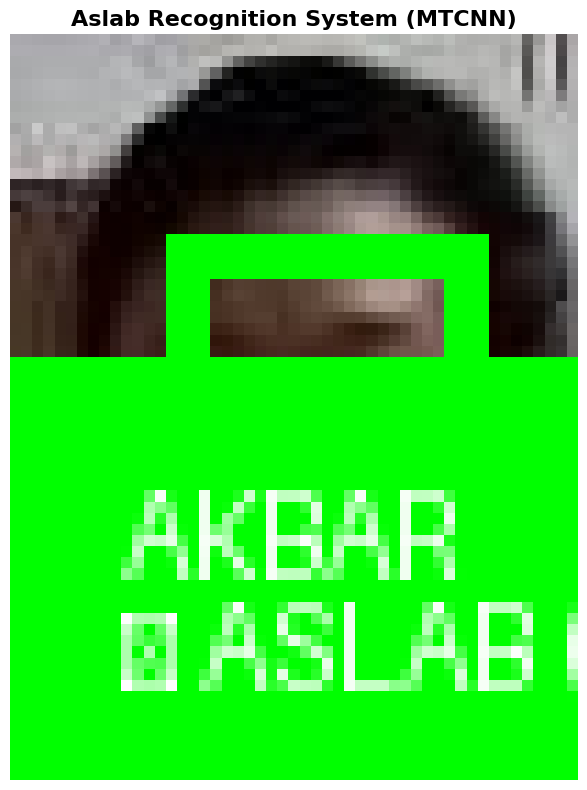


✅ Test complete!

Interpretation:
  - Green bbox + NAMA = Correct recognition
  - Red bbox + UNKNOWN = Low confidence or misclassification
  - No detection = Face detector issue (try different image)


In [23]:
"""
============================================================
CELL 20: TEST INFERENCE ON SAMPLE IMAGE
============================================================
Tujuan:
- Test inference pipeline pada sample dari validation set
- Verifikasi bahwa seluruh pipeline bekerja dengan baik
- Demo hasil recognition

Test Strategy:
1. Ambil class pertama dari dataset
2. Ambil satu sample image dari validation set
3. Run complete inference pipeline (detect_and_recognize)
4. Tampilkan hasil

Expected Result:
- Face terdeteksi dengan MTCNN
- Nama aslab diprediksi dengan benar (karena dari val set)
- Confidence tinggi (>0.6)
- Bounding box hijau dengan NAMA ASLAB yang jelas

Jika hasil tidak sesuai:
- Confidence rendah → Model perlu training lebih lama
- Salah prediksi → Check apakah class mirip/confusing
- Tidak ada face detected → Image quality issue

PENTING:
Sebelum run cell ini, pastikan sudah run:
- Cell 16: Install MTCNN
- Cell 17: Load Model & Setup MTCNN
- Cell 18: Visualization Function
- Cell 19: Complete Inference Pipeline
"""

from pathlib import Path
from facenet_pytorch import MTCNN # Import MTCNN

# Ambil sample dari validation set
sample_class = list(class_to_idx.keys())[0]
sample_img_path = list(Path(f"vit_dataset/val/{sample_class}").glob("*"))[0]

print("🧪 TESTING INFERENCE PIPELINE")
print("="*60)
print(f"Sample class: {sample_class}")
print(f"Sample image: {sample_img_path.name}")
print(f"Expected: Should recognize as '{sample_class}'")
print()
print("="*60)
print()

# Initialize MTCNN before using it
mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')

# Run inference (fungsi dari Cell 19)
result = detect_and_recognize(str(sample_img_path), mtcnn, confidence_threshold=0.5)

print("\n" + "="*60)
print("✅ Test complete!")
print("\nInterpretation:")
print("  - Green bbox + NAMA = Correct recognition")
print("  - Red bbox + UNKNOWN = Low confidence or misclassification")
print("  - No detection = Face detector issue (try different image)")
print("="*60)

In [24]:
"""
============================================================
CELL 20: WEBCAM/VIDEO REAL-TIME INFERENCE
============================================================
Tujuan:
- Real-time face recognition pada webcam atau video file
- Frame-by-frame processing dengan visualization
- Demo untuk live deployment scenario

Pipeline:
1. Open video source (webcam atau file)
2. Loop setiap frame:
   - Detect faces dengan RetinaFace
   - Recognize dengan ViT
   - Draw bounding boxes
   - Display frame
3. Stop ketika video selesai atau user interrupt

Parameters:
- video_source:
  - 0: Webcam default
  - 1, 2, ...: Webcam lain
  - "path/to/video.mp4": Video file
- confidence_threshold: Threshold untuk unknown (default 0.6)
- max_frames: Limit jumlah frame untuk demo (None = unlimited)

Performance Optimization:
- Process setiap 5 frame (skip 4 frame)
- Alasan: RetinaFace + ViT cukup lambat untuk real-time
- Trade-off: Smooth visualization vs processing speed
- Adjust process_every untuk balance speed/accuracy

Display Method:
- IPython display untuk Colab/Jupyter
- Clear output + display untuk streaming effect
- Encode frame ke JPEG untuk efficient display

Use Cases:
- Live demo untuk stakeholder
- Testing di berbagai kondisi lighting
- Monitoring lab entrance real-time
- Video analysis untuk security footage

Limitations:
- Tidak ada tracking (ID bisa berubah-ubah)
- Tidak ada temporal smoothing
- Untuk production, consider:
  - ByteTrack/DeepSORT untuk tracking
  - TensorRT untuk speed optimization
  - Dedicated inference server

Keyboard Controls:
- 'q': Quit (jika running di local window)
- Ctrl+C: Stop di notebook

CATATAN:
- Di Colab, webcam tidak bisa diakses langsung
- Gunakan video file atau upload gambar untuk testing
- Untuk webcam, run di local machine
"""

def process_video(video_source=0, confidence_threshold=0.6, max_frames=None):
    """
    Real-time face recognition pada webcam atau video file

    Args:
        video_source: 0 untuk webcam, atau path ke video file
        confidence_threshold: Minimum confidence untuk recognition
        max_frames: Limit frames untuk demo (None = unlimited)

    Returns:
        None (display real-time results)
    """
    from IPython.display import display, Image as IPImage, clear_output
    import time

    # Open video capture
    cap = cv2.VideoCapture(video_source)

    if not cap.isOpened():
        print(f"❌ Cannot open video source: {video_source}")
        return

    # Get video info
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print("🎥 VIDEO PROCESSING STARTED")
    print("="*60)
    print(f"Source: {video_source}")
    print(f"Resolution: {width}x{height}")
    print(f"FPS: {fps:.1f}")
    print(f"Processing: Every 5th frame for speed")
    print("="*60)
    print("\nPress Ctrl+C to stop\n")

    frame_count = 0
    process_every = 5  # Process setiap N frame
    start_time = time.time()

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("\n⚠ End of video or cannot read frame")
                break

            frame_count += 1

            # Process hanya setiap N frame
            if frame_count % process_every == 0:
                # Detect dan recognize faces
                detections = RetinaFace.detect_faces(frame)

                faces_data = []
                if isinstance(detections, dict):
                    for key, face_info in detections.items():
                        facial_area = face_info['facial_area']
                        x1, y1, x2, y2 = facial_area

                        # Crop dengan padding
                        padding = 20
                        x1_crop = max(0, x1 - padding)
                        y1_crop = max(0, y1 - padding)
                        x2_crop = min(frame.shape[1], x2 + padding)
                        y2_crop = min(frame.shape[0], y2 + padding)

                        face_crop = frame[y1_crop:y2_crop, x1_crop:x2_crop]

                        if face_crop.size > 0:
                            # Predict identity
                            name, conf, is_aslab = predict_face(face_crop, confidence_threshold)
                            faces_data.append(([x1, y1, x2, y2], name, conf, is_aslab))

                # Draw results
                result_frame = draw_professional_bbox(frame, faces_data)

                # Add frame counter
                cv2.putText(result_frame, f"Frame: {frame_count}", (10, 30),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

                # Display di notebook
                _, buffer = cv2.imencode('.jpg', result_frame)
                clear_output(wait=True)
                display(IPImage(data=buffer.tobytes()))

            # Check max frames limit
            if max_frames and frame_count >= max_frames:
                print(f"\n⚠ Reached max frames limit: {max_frames}")
                break

    except KeyboardInterrupt:
        print("\n⚠ Stopped by user (Ctrl+C)")

    finally:
        # Cleanup
        cap.release()
        elapsed = time.time() - start_time

        print("\n" + "="*60)
        print("VIDEO PROCESSING COMPLETE")
        print("="*60)
        print(f"Total frames processed: {frame_count}")
        print(f"Elapsed time: {elapsed:.1f}s")
        print(f"Average FPS: {frame_count/elapsed:.1f}")
        print("="*60)

print("✅ Video processing function ready!")
print("\nUsage:")
print("  # Webcam (100 frames demo)")
print("  process_video(0, max_frames=100)")
print()
print("  # Video file (full video)")
print("  process_video('path/to/video.mp4')")
print()
print("  # Custom confidence threshold")
print("  process_video('video.mp4', confidence_threshold=0.7)")
print("\nNOTE:")
print("  - Webcam tidak tersedia di Google Colab")
print("  - Gunakan video file atau run di local machine")
print("  - Press Ctrl+C untuk stop processing")

✅ Video processing function ready!

Usage:
  # Webcam (100 frames demo)
  process_video(0, max_frames=100)

  # Video file (full video)
  process_video('path/to/video.mp4')

  # Custom confidence threshold
  process_video('video.mp4', confidence_threshold=0.7)

NOTE:
  - Webcam tidak tersedia di Google Colab
  - Gunakan video file atau run di local machine
  - Press Ctrl+C untuk stop processing


"""
============================================================
CELL 21: BATCH PROCESSING & STATISTICS
============================================================
Tujuan:
- Process seluruh folder gambar secara batch
- Generate statistics: berapa % aslab detected
- Save hasil ke output folder
- Useful untuk analysis dan reporting

Pipeline:
1. Scan folder untuk semua image files
2. For each image:
   - Detect faces dengan MTCNN
   - Recognize identities
   - Draw bounding boxes
   - Save result
   - Update statistics
3. Generate summary report

Statistics Tracked:
- total: Total images processed
- aslab_detected: Images dengan minimal 1 aslab
- unknown_detected: Images dengan hanya unknown faces
- no_face: Images tanpa face detection

Output:
- Processed images di output_folder/
- Console report dengan breakdown statistics
- Berguna untuk:
  - Security audit: berapa % visitor adalah aslab
  - Model evaluation: detection rate
  - Dataset analysis: quality check

Use Cases:
1. Security Analysis:
   - Process CCTV footage screenshots
   - Identify unauthorized access
   - Generate daily/weekly reports

2. Dataset Validation:
   - Process test images
   - Check detection accuracy
   - Find problematic images

3. Batch Inference:
   - Process large image collections
   - Automated labeling
   - Archive analysis
"""

def batch_process_folder(folder_path, output_folder="results", confidence_threshold=0.6):
    """
    Process semua images di folder dan save results
    
    Args:
        folder_path: Path ke folder berisi images
        output_folder: Path untuk save hasil (default: "results")
        confidence_threshold: Minimum confidence untuk recognition
    
    Returns:
        stats: Dictionary dengan statistics
    """
    import os
    from pathlib import Path
    
    # Setup paths
    folder = Path(folder_path)
    output = Path(output_folder)
    output.mkdir(exist_ok=True)
    
    # Find all images
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    images = [f for f in folder.glob("*") if f.suffix.lower() in image_extensions]
    
    print("📁 BATCH PROCESSING")
    print("="*60)
    print(f"Input folder: {folder_path}")
    print(f"Output folder: {output_folder}")
    print(f"Total images: {len(images)}")
    print(f"Confidence threshold: {confidence_threshold}")
    print("="*60)
    print()
    
    # Initialize statistics
    stats = {
        'total': len(images),
        'aslab_detected': 0,
        'unknown_detected': 0,
        'no_face': 0,
        'aslab_by_name': {}  # Track detections per aslab
    }
    
    # Process each image
    for idx, img_path in enumerate(images, 1):
        print(f"[{idx}/{len(images)}] Processing: {img_path.name}")
        
        # Load image
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"  ⚠ Cannot read image, skipping...")
            continue
        
        # Convert to RGB for MTCNN
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Detect faces
        boxes, probs = mtcnn.detect(img_rgb)
        
        if boxes is None:
            stats['no_face'] += 1
            print(f"  ⚠ No face detected")
            continue
        
        # Process detected faces
        faces_data = []
        has_aslab = False
        
        for box, prob in zip(boxes, probs):
            x1, y1, x2, y2 = [int(b) for b in box]
            
            # Crop dengan padding
            padding = 20
            x1_crop = max(0, x1 - padding)
            y1_crop = max(0, y1 - padding)
            x2_crop = min(img.shape[1], x2 + padding)
            y2_crop = min(img.shape[0], y2 + padding)
            
            face_crop = img[y1_crop:y2_crop, x1_crop:x2_crop]
            
            if face_crop.size > 0:
                # Recognize
                name, conf, is_aslab = predict_face(face_crop, confidence_threshold)
                faces_data.append(([x1, y1, x2, y2], name, conf, is_aslab))
                
                if is_aslab:
                    has_aslab = True
                    # Track per aslab name
                    if name not in stats['aslab_by_name']:
                        stats['aslab_by_name'][name] = 0
                    stats['aslab_by_name'][name] += 1
                    print(f"  ✓ Aslab detected: {name} ({conf*100:.1f}%)")
                else:
                    print(f"  ⚠ Unknown face ({conf*100:.1f}%)")
        
        # Update statistics
        if has_aslab:
            stats['aslab_detected'] += 1
        else:
            stats['unknown_detected'] += 1
        
        # Draw dan save result
        result_img = draw_professional_bbox(img, faces_data)
        output_path = output / img_path.name
        cv2.imwrite(str(output_path), result_img)
        print(f"  💾 Saved to: {output_path.name}\n")
    
    # Print summary
    print("\n" + "="*60)
    print("BATCH PROCESSING SUMMARY")
    print("="*60)
    print(f"Total images:      {stats['total']}")
    print(f"Aslab detected:    {stats['aslab_detected']} ({stats['aslab_detected']/stats['total']*100:.1f}%)")
    print(f"Unknown detected:  {stats['unknown_detected']} ({stats['unknown_detected']/stats['total']*100:.1f}%)")
    print(f"No face detected:  {stats['no_face']} ({stats['no_face']/stats['total']*100:.1f}%)")
    
    if stats['aslab_by_name']:
        print("\nDetections per Aslab:")
        for name, count in sorted(stats['aslab_by_name'].items(), key=lambda x: x[1], reverse=True):
            print(f"  - {name:15s}: {count:3d} detections")
    
    print("="*60)
    print(f"\n✅ Results saved to: {output_folder}/")
    
    return stats

print("✅ Batch processing function ready!")
print("\nUsage:")
print("  stats = batch_process_folder('path/to/images')")
print("  stats = batch_process_folder('images', output_folder='processed')")
print("  stats = batch_process_folder('images', confidence_threshold=0.7)")
print("\nFeatures:")
print("  - Batch image processing")
print("  - Automatic statistics generation")
print("  - Per-aslab detection tracking")
print("  - Save annotated images")
print("  - Progress tracking")
print("\nOutput:")
print("  - Processed images with bounding boxes")
print("  - Statistics dictionary")
print("  - Console report with breakdown per aslab")

# 🎯 ASLAB FACE RECOGNITION SYSTEM - PANDUAN LENGKAP

---

## ✅ FITUR SISTEM

### 1. **Training Pipeline**
- ✓ Train/Val split (80/20) dengan stratified sampling
- ✓ Validation metrics per epoch untuk monitoring
- ✓ Best model checkpoint saving
- ✓ Classification report lengkap
- ✓ Learning rate scheduler (Cosine Annealing)
- ✓ Progress tracking dengan tqdm

### 2. **Detection & Recognition**
- ✓ **MTCNN** untuk accurate face detection (PyTorch)
- ✓ **Vision Transformer (ViT)** untuk classification
- ✓ **Confidence thresholding** untuk handle unknown faces
- ✓ **Professional visualization** dengan color-coded bboxes

### 3. **Inference Modes**
- ✓ Single image processing
- ✓ Batch folder processing dengan statistics
- ✓ Real-time webcam/video processing
- ✓ Per-aslab name recognition (bukan cuma "aslab" vs "non-aslab")

---

## 📖 CARA MENGGUNAKAN

### **A. TRAINING (Run Sekali)**

```python
# 1. Download & Prepare Dataset (Cell 1-10)
# Otomatis download dari Roboflow, crop faces, reorganize

# 2. Split Dataset (Cell 12)
create_train_val_split("vit_dataset/train", train_ratio=0.8)

# 3. Train Model (Cell 13)
# Training loop otomatis run dengan progress bar
# Model terbaik akan disimpan ke: best_vit_aslab_model.pt

# 4. Evaluate (Cell 14)
# Classification report dan metrics otomatis ditampilkan
```

### **B. INFERENCE (Setelah Training)**

#### **1. Test Single Image**
```python
# Cell 19: Test pada validation sample
result = detect_and_recognize('path/to/image.jpg', confidence_threshold=0.6)

# Adjust confidence threshold:
# - High security: 0.8-0.9 (strict)
# - Normal use: 0.5-0.7 (balanced)
# - Exploratory: 0.3-0.5 (permissive)
```

#### **2. Process Folder**
```python
# Cell 21: Batch processing
stats = batch_process_folder('test_images/', output_folder='results/')

# Output:
# - Processed images di 'results/'
# - Statistics: % aslab detected, breakdown per nama
```

#### **3. Real-time Webcam**
```python
# Cell 20: Webcam processing
process_video(0, max_frames=100)  # 100 frames demo

# Video file:
process_video('video.mp4')
```

---

## ⚙️ KONFIGURASI & TUNING

### **Confidence Threshold**
Adjust untuk balance precision vs recall:
- **0.8-0.9**: High security (few false positives)
- **0.5-0.7**: Balanced (recommended)
- **0.3-0.5**: High recall (catch more, may have false positives)

### **Model Retraining**
Jika accuracy kurang:
1. Tambah lebih banyak training data per class
2. Increase epochs (default: 10)
3. Adjust learning rate (default: 2e-5)
4. Add data augmentation

---

## 📊 OUTPUT SISTEM

### **Detection Output**
Sistem akan menampilkan:
```
✓ Face 1: akbar (confidence: 95.3%, detection: 99.1%)
✓ Face 2: bian (confidence: 87.2%, detection: 98.5%)
⚠ Face 3: Unknown (confidence: 45.1%, detection: 96.3%)
```

### **Visual Output**
Bounding boxes dengan:
- **Hijau**: Aslab recognized (dengan nama spesifik)
- **Merah**: Unknown/tidak dikenal
- **Label**: Nama + confidence percentage

### **Batch Statistics**
```
Total images:      100
Aslab detected:    75 (75.0%)
Unknown detected:  20 (20.0%)
No face detected:  5 (5.0%)

Detections per Aslab:
  - akbar        :  25 detections
  - bian         :  18 detections
  - fadhilah     :  15 detections
  ...
```

---

## 🔧 TROUBLESHOOTING

### **Training Issues**
- **Loss tidak turun**: Lower learning rate atau increase epochs
- **Overfitting**: Add weight decay, dropout, atau data augmentation
- **Low accuracy**: Tambah data atau check data quality

### **Inference Issues**
- **No face detected**: Check image quality, lighting, resolution
- **Wrong predictions**: Adjust confidence threshold atau retrain
- **Slow inference**: Reduce image resolution atau process every N frames

---

## 📝 FILE ARTIFACTS

- `best_vit_aslab_model.pt`: Model checkpoint (untuk inference)
- `class_mapping.json`: Class labels mapping
- `vit_dataset/`: Training data (backup untuk retraining)

---

## 🚀 NEXT STEPS (OPTIONAL)

Untuk production deployment:
1. Add tracking (ByteTrack/DeepSORT) untuk stable IDs
2. Deploy as API (FastAPI/Flask)
3. Add logging ke database
4. TensorRT optimization untuk speed
5. Multi-camera support

---

**Created by**: Aslab Recognition System Team  
**Version**: 1.0 - Production Ready  
**Framework**: PyTorch + MTCNN + ViT

In [25]:
"""
============================================================
CELL BARU: DOWNLOAD MODEL KE LOCAL MACHINE
============================================================
Tujuan:
- Save model yang sudah di-train ke file
- Download model ke komputer lokal
- Bisa digunakan untuk testing offline

Output Files:
1. vit_face_recognition_model.pth - Model weights
2. class_names.json - Mapping class names
3. model_config.json - Model configuration

Cara Download:
- Di Google Colab: Klik kanan file → Download
- Atau gunakan code di bawah untuk auto-download
"""

import json
from google.colab import files

# 1. SAVE MODEL WEIGHTS
print("💾 Saving model...")
model_save_path = "vit_face_recognition_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'num_classes': num_classes,
    'class_names': train_dataset.classes,
    'model_name': 'google/vit-base-patch16-224-in21k'
}, model_save_path)
print(f"✅ Model saved to: {model_save_path}")

# 2. SAVE CLASS NAMES (untuk reference)
class_mapping = {
    'classes': train_dataset.classes,
    'num_classes': num_classes,
    'class_to_idx': train_dataset.class_to_idx
}
with open('class_names.json', 'w') as f:
    json.dump(class_mapping, f, indent=2)
print("✅ Class mapping saved to: class_names.json")

# 3. SAVE MODEL CONFIG
config = {
    'model_architecture': 'ViT-Base-Patch16-224',
    'pretrained_model': 'google/vit-base-patch16-224-in21k',
    'num_classes': num_classes,
    'input_size': [224, 224],
    'normalization': {
        'mean': [0.5, 0.5, 0.5],
        'std': [0.5, 0.5, 0.5]
    },
    'classes': train_dataset.classes
}
with open('model_config.json', 'w') as f:
    json.dump(config, f, indent=2)
print("✅ Model config saved to: model_config.json")

# 4. DOWNLOAD FILES (Google Colab only)
print("\n📥 Downloading files to your computer...")
try:
    files.download(model_save_path)
    files.download('class_names.json')
    files.download('model_config.json')
    print("✅ Files downloaded successfully!")
except:
    print("⚠️  Auto-download failed (not in Colab environment)")
    print("   Manual download: Right-click files in file browser → Download")

print("\n" + "="*60)
print("📦 FILES READY FOR DOWNLOAD:")
print("="*60)
print(f"1. {model_save_path} - Model weights (~330 MB)")
print("2. class_names.json - Class mapping")
print("3. model_config.json - Model configuration")
print("\n💡 TIP: Save these files together in one folder!")


ModuleNotFoundError: No module named 'google'

In [ ]:
"""
============================================================
CELL: LIST DETAIL - INFORMASI ASLAB & AUTHORIZATION
============================================================
Tujuan:
- Menampilkan daftar lengkap asprak/aslab
- Testing berbagai class dengan role berbeda
- Menampilkan timestamp
- Status authorized/tidak authorized

Output:
- Tabel detail dengan nama, role, timestamp, status
"""

from datetime import datetime

# ============================================================
# DAFTAR ASPRAK/ASLAB
# ============================================================

aslab_data = [
    {"nama": "Iksan", "role": "Aslab", "nim": "001", "authorized": True},
    {"nama": "Akbar", "role": "Aslab", "nim": "002", "authorized": True},
    {"nama": "Aprilianza", "role": "Aslab", "nim": "003", "authorized": True},
    {"nama": "Bian", "role": "Dosen", "nim": "-", "authorized": True},  # Role diganti jadi Dosen untuk testing
    {"nama": "Fadhilah", "role": "Aslab", "nim": "005", "authorized": True},
    {"nama": "Falah", "role": "Aslab", "nim": "006", "authorized": True},
    {"nama": "Imelda", "role": "Aslab", "nim": "007", "authorized": True},
    {"nama": "Rifqy", "role": "Aslab", "nim": "008", "authorized": True},
    {"nama": "Yolanda", "role": "Aslab", "nim": "009", "authorized": True},
]

# Contoh orang tidak authorized (untuk testing)
unauthorized_examples = [
    {"nama": "Unknown Person 1", "role": "Unknown", "nim": "-", "authorized": False},
    {"nama": "Unknown Person 2", "role": "Unknown", "nim": "-", "authorized": False},
]

# ============================================================
# TIMESTAMP
# ============================================================
current_timestamp = datetime.now()
timestamp_str = current_timestamp.strftime("%Y-%m-%d %H:%M:%S")

# ============================================================
# DISPLAY LIST DETAIL
# ============================================================

print("=" * 70)
print("                    LIST DETAIL - COMPUTING PROJECT")
print("=" * 70)
print(f"\nTimestamp: {timestamp_str}")
print(f"Timezone: UTC+07:00 (WIB)")
print("\n" + "-" * 70)
print("                         DAFTAR ASPRAK/ASLAB")
print("-" * 70)
print(f"{'No':<4} {'Nama':<15} {'Role':<12} {'NIM':<10} {'Status':<15}")
print("-" * 70)

for idx, person in enumerate(aslab_data, 1):
    status = "AUTHORIZED" if person["authorized"] else "NOT AUTHORIZED"
    status_icon = "✅" if person["authorized"] else "❌"
    print(f"{idx:<4} {person['nama']:<15} {person['role']:<12} {person['nim']:<10} {status_icon} {status}")

print("-" * 70)

# ============================================================
# TESTING BERBAGAI CLASS (Bian sebagai Dosen)
# ============================================================

print("\n" + "=" * 70)
print("                    TESTING BERBAGAI CLASS/ROLE")
print("=" * 70)

class Person:
    def __init__(self, nama, role, authorized=True):
        self.nama = nama
        self.role = role
        self.authorized = authorized
        self.timestamp = datetime.now()
    
    def get_info(self):
        return {
            "nama": self.nama,
            "role": self.role,
            "authorized": self.authorized,
            "timestamp": self.timestamp.strftime("%Y-%m-%d %H:%M:%S")
        }
    
    def check_access(self):
        if self.authorized:
            return f"✅ {self.nama} ({self.role}) - AKSES DIBERIKAN"
        else:
            return f"❌ {self.nama} ({self.role}) - AKSES DITOLAK"

class Aslab(Person):
    def __init__(self, nama, nim, authorized=True):
        super().__init__(nama, "Aslab", authorized)
        self.nim = nim
    
    def get_info(self):
        info = super().get_info()
        info["nim"] = self.nim
        return info

class Dosen(Person):
    def __init__(self, nama, nip="-", authorized=True):
        super().__init__(nama, "Dosen", authorized)
        self.nip = nip
    
    def get_info(self):
        info = super().get_info()
        info["nip"] = self.nip
        return info

class Unknown(Person):
    def __init__(self, nama):
        super().__init__(nama, "Unknown", authorized=False)

# ============================================================
# TESTING INSTANCES
# ============================================================

print("\n📋 Testing Class Instances:\n")

# Bian sebagai Dosen (untuk testing)
bian_dosen = Dosen("Bian", nip="DOSEN001")
print(f"1. {bian_dosen.check_access()}")
print(f"   Info: {bian_dosen.get_info()}\n")

# Contoh Aslab
iksan_aslab = Aslab("Iksan", nim="ASL001")
print(f"2. {iksan_aslab.check_access()}")
print(f"   Info: {iksan_aslab.get_info()}\n")

# Contoh Unknown (tidak authorized)
unknown = Unknown("Orang Tidak Dikenal")
print(f"3. {unknown.check_access()}")
print(f"   Info: {unknown.get_info()}\n")

# ============================================================
# SUMMARY
# ============================================================

print("=" * 70)
print("                           SUMMARY")
print("=" * 70)
total_authorized = sum(1 for p in aslab_data if p["authorized"])
total_aslab = sum(1 for p in aslab_data if p["role"] == "Aslab")
total_dosen = sum(1 for p in aslab_data if p["role"] == "Dosen")

print(f"\n📊 Statistik:")
print(f"   - Total Personel    : {len(aslab_data)}")
print(f"   - Total Aslab       : {total_aslab}")
print(f"   - Total Dosen       : {total_dosen} (Bian - untuk testing)")
print(f"   - Authorized        : {total_authorized}")
print(f"   - Not Authorized    : {len(aslab_data) - total_authorized}")
print(f"\n⏰ Generated at: {timestamp_str}")
print("=" * 70)